In [1]:
#from google.colab import drive
#drive.mount('/content/drive/')

In [2]:
#Set your project path 
#project_path =  "../"
#import os
#os.getcwd()

In [3]:
import numpy as np
import pandas as pd
import re
import json

# EDA


## Read Data

In [4]:
df = pd.read_excel('../input/ittickets/input_data.xlsx')
df.head()

Short description  \
0                    login issue   
1                        outlook   
2             cant log in to vpn   
3  unable to access hr_tool page   
4                   skype error    

                                         Description             Caller  \
0  -verified user details.(employee# & manager na...  spxjnwir pjlcoqds   
1  \r\n\r\nreceived from: hmjdrvpb.komuaywn@gmail...  hmjdrvpb komuaywn   
2  \r\n\r\nreceived from: eylqgodm.ybqkwiam@gmail...  eylqgodm ybqkwiam   
3                      unable to access hr_tool page  xbkucsvz gcpydteq   
4                                       skype error   owlgqjme qhcozdfx   

  Assignment group  
0            GRP_0  
1            GRP_0  
2            GRP_0  
3            GRP_0  
4            GRP_0

In [5]:
df.shape

(8500, 4)

Data has 4 columns: short description, description, caller and Assignment Groups.
From initial observations, there are lots of symbols and punctuations. The description fields also refer to the caller names. There are HTML tags, URL's, email addresses, references to image files etc which need to be cleaned. There are also some rows which are not in English (mostly German).

The target variable (Assignment group) will be studied in more detail further on. 

## Preprocessing

In [6]:
clean_df = df.copy()
clean_df = clean_df.astype(str)

In [7]:
print("Null values in Short description:",clean_df['Short description'].isna().sum())
print("Null values in Description:",clean_df['Description'].isna().sum())
print("Null values in Caller:",clean_df['Caller'].isna().sum())
print("Null values in Assignment group:",clean_df['Assignment group'].isna().sum())

Null values in Short description: 0
Null values in Description: 0
Null values in Caller: 0
Null values in Assignment group: 0


No null value treatment is required. There are 2 description fields which do not have any characters, but those will be handled during the data cleaning and merging with short description.

In [8]:
#clean_df['Description'].fillna(value=' ', inplace=True)


### Language Detection

Language detection works best before the text is further processed.

In [9]:
!pip install langdetect
from langdetect import detect
clean_df['Language'] = ""
for i, desc in enumerate(clean_df['Description']):
  try:
    clean_df['Language'][i] = detect(desc)
  except:
    clean_df['Language'][i] = 'unknown'
    

     |████████████████████████████████| 981 kB 1.4 MB/s 
  Created wheel for langdetect: filename=langdetect-1.0.8-py3-none-any.whl size=993191 sha256=f9b4aebf12e0a4db761360fe4516a5cc342249f659381da01192a055c401f723
  Stored in directory: /root/.cache/pip/wheels/59/f6/9d/85068904dba861c0b9af74e286265a08da438748ee5ae56067
Successfully built langdetect
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [10]:
clean_df['Language'].value_counts()

en         7015
de          402
af          262
it          141
fr          124
sv           82
no           73
da           66
nl           63
es           61
ca           50
pl           30
pt           28
ro           16
cy           13
tl           12
sl           11
sq            9
fi            7
et            7
id            6
hr            5
tr            5
unknown       3
cs            2
so            2
lv            2
sk            1
sw            1
lt            1
Name: Language, dtype: int64

Looking at the detected languages, the language detection has not done a very good job of detecting languages. It has mostly correctly detected English and German and most other languages detected should have been marked as English. Therefore, we will only treat the German words (after cleaning the data).

In [11]:
clean_df.loc[clean_df['Language']!='de','Language'] = 'en'

In [12]:
clean_df['Language'].value_counts()

en    8098
de     402
Name: Language, dtype: int64

### Clean


In [13]:
import string
callers = clean_df['Caller'].tolist()

def clean_data(text):
    text = text.lower()
    #text = ' '.join([w for w in text.split() if not is_valid_date(w)])
    # Remove email template
    text = re.sub(r"(received from:|from:|to:|sent:|ic:|cc:|bcc:).*\n",' ',text)
    text = re.sub(r"subject:",' ',text)

    #Remove email addresses
    text = re.sub(r'\S*@\S*\s?', '', text)

    # Remove numbers 
    text = re.sub(r'\s*\d+','' ,text)

    # Remove new line characters 
    text = re.sub(r'\n',' ',text)

    # Remove hashtag while keeping hashtag text
    #text = re.sub(r'#','', text)

    # Remove & 
    #text = re.sub(r'&;?', 'and',text)

    # Remove HTML special entities (e.g. &amp;)
    text = re.sub(r'\&\w*;', '', text)

    # Remove hyperlinks
    text = re.sub(r'https?:\/\/.*\/\w*', '', text) 

    # Remove characters beyond Readable formart by Unicode:
    text= ''.join(c for c in text if c <= '\uFFFF') 

    # Remove unreadable characters  (also extra spaces)
    text = ' '.join(re.sub("[^\u0030-\u0039\u0041-\u005a\u0061-\u007a]", " ", text).split())
    
    # Remove punctuations
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Remove caller names
    for caller in callers:
        caller_names = [name for name in caller.split()]
        for name in caller_names: 
            text = text.replace(name,'')       
   
    text = text.strip()
    text = ' '.join(text.split())

    return text

In [14]:
# Merge short description and description fields after cleaning them
clean_df['Description'] = clean_df['Description'].apply(clean_data)
clean_df['Short description'] = clean_df['Short description'].apply(clean_data)
clean_df['Description'] = clean_df['Description'] +" "+ clean_df['Short description']

In [15]:
# Now drop short description
clean_df.drop('Short description', axis=1, inplace=True)
clean_df.head()

Description             Caller  \
0  verified user details employee manager name ch...  spxjnwir pjlcoqds   
1  hello team my meetings skype meetings etc are ...  hmjdrvpb komuaywn   
2  hi i cannot log on to vpn best cant log in to vpn  eylqgodm ybqkwiam   
3  unable to access hr tool page unable to access...  xbkucsvz gcpydteq   
4                            skype error skype error  owlgqjme qhcozdfx   

  Assignment group Language  
0            GRP_0       en  
1            GRP_0       en  
2            GRP_0       en  
3            GRP_0       en  
4            GRP_0       en

### Translate German entries to English

In [16]:
!pip install -q googletrans
from googletrans import Translator

translator = Translator()

translations = clean_df[clean_df['Language']=='de']['Description'].apply(lambda x: translator.translate(x).text)

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [17]:
clean_df.loc[clean_df['Language']=='de','Description'] = translations
clean_df.loc[223]

Description         hello it happened again the pc hung itself up ...
Caller                                              vrfpyjwi nzhvgqiw
Assignment group                                               GRP_24
Language                                                           de
Name: 223, dtype: object

In [18]:
clean_df.to_excel('cleaned_data.xlsx')

### Stopword Removal & Lemmatization 

In [19]:
import nltk
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger') 

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [20]:
# Remove stopwords
sw_en = stopwords.words('english')
#adding 'please' to stopwords as it was observed in previous iterations that it appears frequently 
#but does not add to context
sw_en.append('please')

for i, desc in enumerate(clean_df['Description']):
    clean_df['Description'][i]=' '.join(word for word in desc.split() if word not in sw_en)
    

In [21]:
clean_df['Description'].apply(lambda x: 'please' in x).any()

True

In [22]:
# Lemmatise

def get_wordnet_pos(word):
    #Map POS tag to first character lemmatize() accepts
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

wordnet_lemmatizer = WordNetLemmatizer()

In [23]:
text = clean_df['Description'][223]
text_words = nltk.word_tokenize(text)

for word in text_words:
    print ("{0:20}{1:20}".format(word,wordnet_lemmatizer.lemmatize(word,pos=get_wordnet_pos(word))))


hello               hello               
happened            happen              
pc                  pc                  
hung                hung                
presented           present             
blue                blue                
screen              screen              
white               white               
letters             letter              
bluescreen          bluescreen          
problems            problem             


In [24]:
def lemmatize_text_en(text):
    words = text.split()
    return ' '.join([wordnet_lemmatizer.lemmatize(word,pos=get_wordnet_pos(word)) for word in words])

clean_df['Description'] = clean_df['Description'].apply(lemmatize_text_en)


In [25]:
clean_df.to_excel('cleaned_data_lem.xlsx')


In [26]:
#clean_df = pd.read_excel('../input/ittickets/cleaned_data_lem.xlsx')
#clean_df

## Topic Modelling

Use BOW and TFIDF for LDA modelling, then compare and visualise the results.

In [27]:
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel, TfidfModel

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim

In [28]:
#Tokenisation
def desc_to_words(descs):
    for desc in descs:
        yield(gensim.utils.simple_preprocess(str(desc), deacc=True))

data_words = list(desc_to_words(clean_df['Description']))

# check first description
print(data_words[0])

['verify', 'user', 'detail', 'employee', 'manager', 'name', 'checked', 'user', 'name', 'ad', 'reset', 'password', 'advise', 'user', 'login', 'check', 'caller', 'confirm', 'able', 'login', 'issue', 'resolve', 'login', 'issue']


In [29]:
# Create Dictinoary
id2word = corpora.Dictionary(data_words)
vocab_size = len(id2word)
print("Vocab size = ", vocab_size)

# Create Corpus
texts = data_words

# Term Document Frequency (Bag of Words)
bow_corpus = [id2word.doc2bow(text) for text in texts]

tfidf = TfidfModel(bow_corpus)
tfidf_corpus = tfidf[bow_corpus]

# View BOW and TFIDF for the first description
print(bow_corpus[0])
print(tfidf_corpus[0])


Vocab size =  10030
[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 2), (10, 3), (11, 1), (12, 2), (13, 1), (14, 1), (15, 1), (16, 3), (17, 1)]
[(0, 0.1605522819925148), (1, 0.2250048756366594), (2, 0.2124523834561448), (3, 0.24094141743849676), (4, 0.16572617932580694), (5, 0.24032382849930964), (6, 0.20964979563079159), (7, 0.1943817307841616), (8, 0.20384541286589686), (9, 0.22579009164313457), (10, 0.46040250781814857), (11, 0.17792526116762955), (12, 0.2936393693548971), (13, 0.10785813383400042), (14, 0.11853003522783245), (15, 0.18507972984505708), (16, 0.36515943217178487), (17, 0.1943817307841616)]


In [30]:
# Readable format of BOW corpus (term-frequency) for first description
[[(id2word[id], freq) for id, freq in cp] for cp in bow_corpus[:1]]

[[('able', 1),
  ('ad', 1),
  ('advise', 1),
  ('caller', 1),
  ('check', 1),
  ('checked', 1),
  ('confirm', 1),
  ('detail', 1),
  ('employee', 1),
  ('issue', 2),
  ('login', 3),
  ('manager', 1),
  ('name', 2),
  ('password', 1),
  ('reset', 1),
  ('resolve', 1),
  ('user', 3),
  ('verify', 1)]]

In [31]:
# Readable format of TFIDF corpus for first description
[[(id2word[id], tfi) for id, tfi in cp] for cp in tfidf_corpus[:1]]

[[('able', 0.1605522819925148),
  ('ad', 0.2250048756366594),
  ('advise', 0.2124523834561448),
  ('caller', 0.24094141743849676),
  ('check', 0.16572617932580694),
  ('checked', 0.24032382849930964),
  ('confirm', 0.20964979563079159),
  ('detail', 0.1943817307841616),
  ('employee', 0.20384541286589686),
  ('issue', 0.22579009164313457),
  ('login', 0.46040250781814857),
  ('manager', 0.17792526116762955),
  ('name', 0.2936393693548971),
  ('password', 0.10785813383400042),
  ('reset', 0.11853003522783245),
  ('resolve', 0.18507972984505708),
  ('user', 0.36515943217178487),
  ('verify', 0.1943817307841616)]]

In [32]:
#Build an LDA model using BOW corpus
lda_model_bow = gensim.models.ldamodel.LdaModel(corpus=bow_corpus,
                                           id2word=id2word,
                                           num_topics=10, 
                                           random_state=7,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [33]:
from pprint import pprint
pprint(lda_model_bow.print_topics())

[(0,
  '0.057*"group" + 0.033*"service" + 0.033*"screen" + 0.028*"aug" + '
  '0.025*"information" + 0.022*"drive" + 0.020*"ethic" + 0.020*"let" + '
  '0.019*"folder" + 0.019*"report"'),
 (1,
  '0.106*"user" + 0.064*"issue" + 0.051*"outlook" + 0.048*"server" + '
  '0.041*"request" + 0.032*"team" + 0.028*"connection" + 0.022*"port" + '
  '0.021*"system" + 0.020*"login"'),
 (2,
  '0.035*"error" + 0.030*"work" + 0.021*"see" + 0.020*"get" + 0.017*"message" '
  '+ 0.016*"file" + 0.015*"order" + 0.015*"hello" + 0.014*"issue" + '
  '0.014*"crm"'),
 (3,
  '0.053*"account" + 0.052*"company" + 0.046*"device" + 0.045*"email" + '
  '0.040*"lock" + 0.036*"window" + 0.028*"ip" + 0.028*"pc" + 0.024*"phone" + '
  '0.024*"new"'),
 (4,
  '0.419*"job" + 0.158*"scheduler" + 0.120*"abended" + 0.053*"fail" + '
  '0.039*"sid" + 0.015*"hana" + 0.014*"cold" + 0.007*"bk" + 0.007*"dp" + '
  '0.005*"bkwin"'),
 (5,
  '0.350*"password" + 0.205*"reset" + 0.079*"software" + 0.047*"block" + '
  '0.032*"would" + 0.024*"

In [34]:
# Compute Perplexity
print('Perplexity: ', lda_model_bow.log_perplexity(bow_corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda_bow = CoherenceModel(model=lda_model_bow, texts=data_words, dictionary=id2word, coherence='c_v')
coherence_lda_bow = coherence_model_lda_bow.get_coherence()
print('\nCoherence Score: ', coherence_lda_bow)

Perplexity:  -7.259254961222583

Coherence Score:  0.4683522818355872


In [35]:
#Build an LDA model using BOW corpus
lda_model_tfi = gensim.models.ldamodel.LdaModel(corpus=tfidf_corpus,
                                           id2word=id2word,
                                           num_topics=10, 
                                           random_state=7,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [36]:
pprint(lda_model_tfi.print_topics())

[(0,
  '0.059*"software" + 0.047*"screen" + 0.018*"come" + 0.015*"boot" + '
  '0.011*"station" + 0.008*"product" + 0.008*"needful" + 0.006*"blue" + '
  '0.001*"talk" + 0.001*"play"'),
 (1,
  '0.050*"change" + 0.047*"server" + 0.025*"disk" + 0.019*"report" + '
  '0.019*"connection" + 0.014*"probleme" + 0.013*"gb" + 0.013*"submit" + '
  '0.012*"wireless" + 0.011*"kind"'),
 (2,
  '0.020*"issue" + 0.017*"outlook" + 0.015*"access" + 0.015*"ticket" + '
  '0.015*"hostname" + 0.014*"error" + 0.014*"update" + 0.014*"work" + '
  '0.013*"new" + 0.011*"company"'),
 (3,
  '0.121*"lock" + 0.030*"pc" + 0.021*"sale" + 0.019*"load" + 0.015*"lockout" + '
  '0.013*"desktop" + 0.013*"folder" + 0.013*"item" + 0.013*"save" + '
  '0.012*"note"'),
 (4,
  '0.229*"job" + 0.120*"abended" + 0.088*"scheduler" + 0.029*"fail" + '
  '0.019*"cold" + 0.018*"ad" + 0.014*"telephony" + 0.011*"hana" + '
  '0.008*"confirm" + 0.007*"advise"'),
 (5,
  '0.096*"window" + 0.075*"request" + 0.014*"card" + 0.006*"reach" + '
  '0.0

In [37]:
# Compute Perplexity
print('Perplexity: ', lda_model_tfi.log_perplexity(tfidf_corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda_tfi = CoherenceModel(model=lda_model_tfi, texts=data_words, dictionary=id2word, coherence='c_v')
coherence_lda_tfi = coherence_model_lda_tfi.get_coherence()
print('\nCoherence Score: ', coherence_lda_tfi)

Perplexity:  -9.150087828286722

Coherence Score:  0.48560749799883995


TFIDF modek has a slightly better coherency and perplexity score than that of BOW.

In [38]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model_bow, bow_corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.192366 -0.071362       1        1  18.897112
7      0.234986  0.117940       2        1  16.198507
8     -0.148168 -0.082522       3        1  11.051893
3     -0.162755  0.236748       4        1  10.217835
9     -0.153513  0.220561       5        1   9.990217
1      0.221101  0.088088       6        1   9.338141
6     -0.148766 -0.110131       7        1   9.175923
0      0.047115 -0.126581       8        1   6.074667
4     -0.066026 -0.237977       9        1   5.589595
5     -0.016340 -0.034765      10        1   3.466113, topic_info=               Term         Freq        Total Category  logprob  loglift
176             job  4116.000000  4116.000000  Default  30.0000  30.0000
13         password  2133.000000  2133.000000  Default  29.0000  29.0000
102             erp  1905.000000  1905.000000  Default  28.0000  28.0000
200       scheduler  1552.000000  1552.000000  Default  27.0000  27.0000
313             yes  1915.000000  1915.000000  Default  26.0000  26.0000
...             ...          ...          ...      ...      ...      ...
3550         dthyan     9.414909    10.244954  Topic10  -6.4716   3.2776
3551  matheywtyuews     9.414909    10.244954  Topic10  -6.4716   3.2776
14            reset  1246.865601  1379.681030  Topic10  -1.5855   3.2609
7487       adoption     9.551599    10.412660  Topic10  -6.4572   3.2758
11          manager   148.342758   380.860687  Topic10  -3.7144   2.4192

[381 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
7494      9  0.999272  abended
0         2  0.789543     able
0         6  0.208648     able
35        2  0.999763   access
101       4  0.701656  account
...     ...       ...      ...
95        1  0.873311     work
95        5  0.125764     work
667      10  0.996966    would
2072      1  0.997214    wrong
313       5  0.999807      yes

[386 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 8, 9, 4, 10, 2, 7, 1, 5, 6])

In [39]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model_tfi, tfidf_corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.329893 -0.160557       1        1  34.037216
6     -0.204639 -0.305633       2        1  24.154524
7     -0.051491  0.110070       3        1  19.579189
4     -0.018608  0.062710       4        1   7.732065
3     -0.010687  0.052486       5        1   3.449160
8     -0.011135  0.053502       6        1   3.386134
1     -0.010051  0.050849       7        1   3.258527
9     -0.009820  0.050520       8        1   2.211987
5     -0.006973  0.043668       9        1   1.208916
0     -0.006490  0.042384      10        1   0.982277, topic_info=           Term        Freq       Total Category  logprob  loglift
176         job  423.000000  423.000000  Default  30.0000  30.0000
7494    abended  221.000000  221.000000  Default  29.0000  29.0000
13     password  328.000000  328.000000  Default  28.0000  28.0000
200   scheduler  161.000000  161.000000  Default  27.0000  27.0000
103        lock  100.000000  100.000000  Default  26.0000  26.0000
...         ...         ...         ...      ...      ...      ...
6698     leader    0.020111    0.857588  Topic10  -9.3627   0.8702
5073      saver    0.021333   10.011794  Topic10  -9.3037  -1.5282
2398     turkey    0.020364    3.493298  Topic10  -9.3502  -0.5218
9733        mdm    0.020312    2.735721  Topic10  -9.3528  -0.2799
5224         pd    0.020079    0.925122  Topic10  -9.3643   0.7928

[512 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
7494      4  0.998043     abended
0         1  0.996901        able
35        1  0.999765      access
101       2  0.997951     account
438       6  0.985874  activation
...     ...       ...         ...
202       9  0.993235      window
281       7  0.901714    wireless
1704      4  0.873725         wly
95        1  0.994867        work
313       8  0.990045         yes

[272 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 7, 8, 5, 4, 9, 2, 10, 6, 1])

Despite the better score for the TFIDF model, it seems that the BOW model has done a better a job in segregating related topics. Both models confirm our initial impression of group 0 with most tickets begin the group for basic level support, related to passwords and accounts and anything else that is not categorised in other groups. 

## Target Variable - Assignment Group

In [40]:
#import pandas as pd
#clean_df = pd.read_excel('../input/ittickets/cleaned_data_lem.xlsx').astype(str)

In [41]:
clean_df['Assignment group'].describe()

count      8500
unique       74
top       GRP_0
freq       3976
Name: Assignment group, dtype: object

In [42]:
group_vc = clean_df['Assignment group'].value_counts()
group_vc.describe()

count      74.000000
mean      114.864865
std       465.747516
min         1.000000
25%         5.250000
50%        26.000000
75%        84.000000
max      3976.000000
Name: Assignment group, dtype: float64

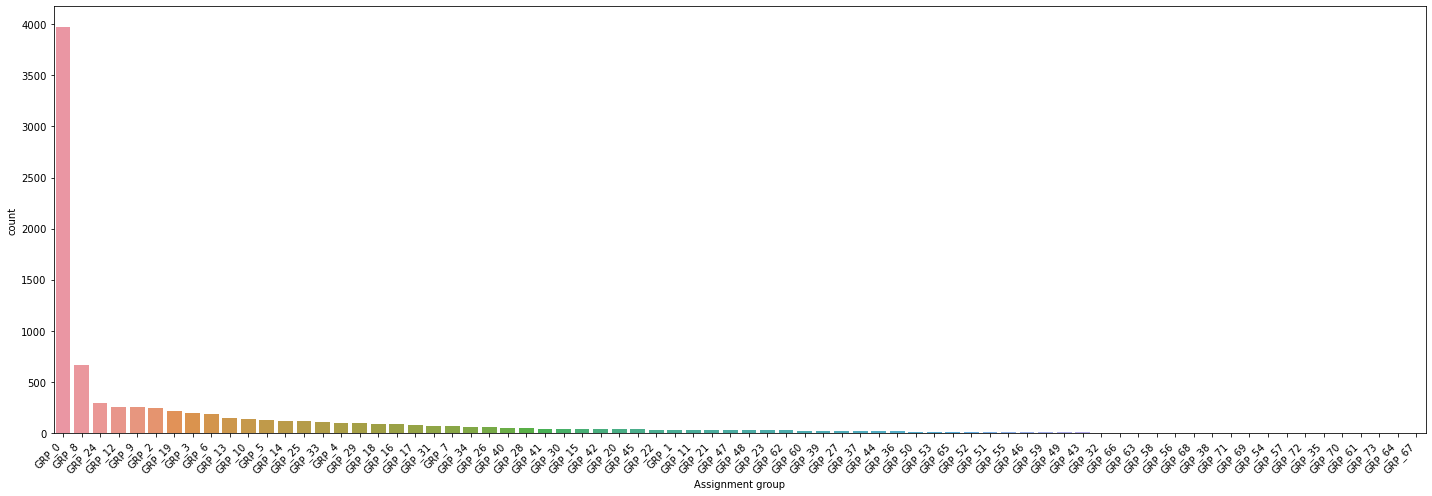

In [43]:
import seaborn as sns
from matplotlib import pyplot as plt

plt.figure(figsize=(20,7))
cplt = sns.countplot(clean_df['Assignment group'],order=group_vc.sort_values(ascending=False).index)
cplt.set_xticklabels(cplt.get_xticklabels(), rotation=45, ha="right")
plt.tight_layout()
plt.show()

There are 74 groups, with the most frequent one being Group 0 with frequncy 3976. The target variable is highly skewed and imbalanced. Not only group 0 has the majority of tickets assigned, the rest of the groups are also imbalanced with more than 25% of the groups having less than 6 tickets assigned, while the more frequent groups have hundreds.

To treat this, we will merge the groups which have less than 10 tickets assigned to them and also resample data to make it balanced.

Studying the texts for different groups suggests that Group 0 is used for generic account management issues and is also the fallback group for anything that is not categorised into other groups, most likely incorrectly so.

In [44]:
# Merge groups with less than 10 items (Q1) into one Miscellaneous group
misc_groups = group_vc[group_vc <= 10].index
misc_groups

Index(['GRP_52', 'GRP_51', 'GRP_55', 'GRP_49', 'GRP_46', 'GRP_59', 'GRP_43',
       'GRP_32', 'GRP_66', 'GRP_63', 'GRP_58', 'GRP_56', 'GRP_68', 'GRP_38',
       'GRP_71', 'GRP_69', 'GRP_54', 'GRP_57', 'GRP_72', 'GRP_64', 'GRP_73',
       'GRP_35', 'GRP_70', 'GRP_61', 'GRP_67'],
      dtype='object')

In [45]:
is_misc = clean_df['Assignment group'].isin(misc_groups)

In [46]:
clean_merged_df = clean_df.copy()
clean_merged_df.loc[is_misc,'Assignment group'] = 'GRP_MISC'

In [47]:
clean_merged_df['Assignment group'].isin(misc_groups).any()

False

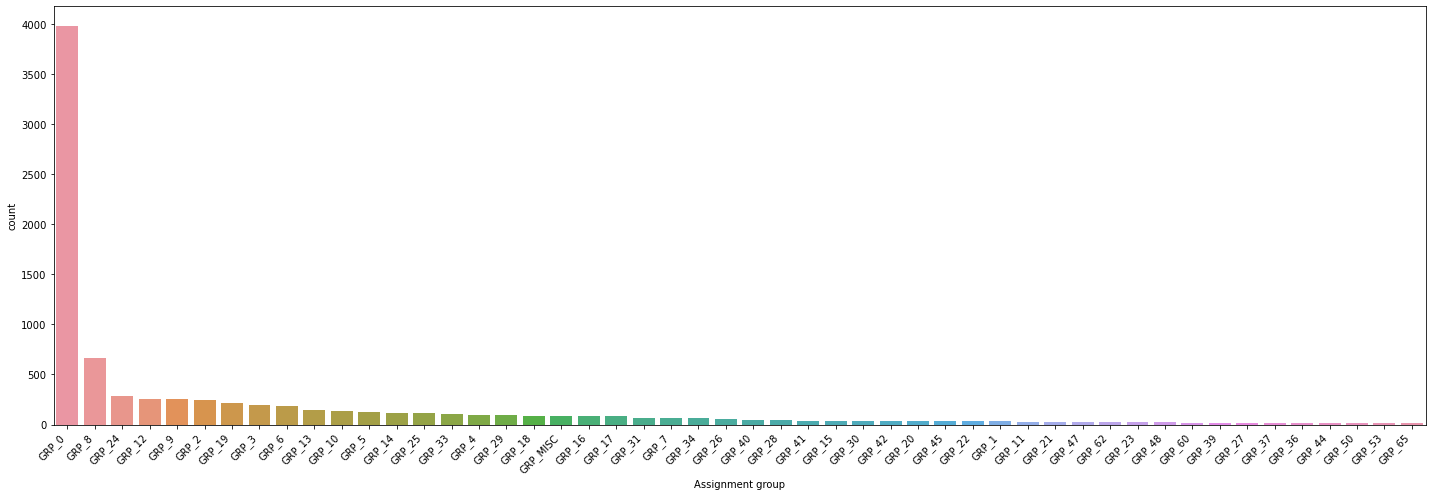

In [48]:
group_vc_new = clean_merged_df['Assignment group'].value_counts()
plt.figure(figsize=(20,7))
cplt = sns.countplot(clean_merged_df['Assignment group'],order=group_vc_new.sort_values(ascending=False).index)
cplt.set_xticklabels(cplt.get_xticklabels(), rotation=45, ha="right")
plt.tight_layout()
plt.show()

Let us view the distribution of tickets for all the groups that are not Group 0.

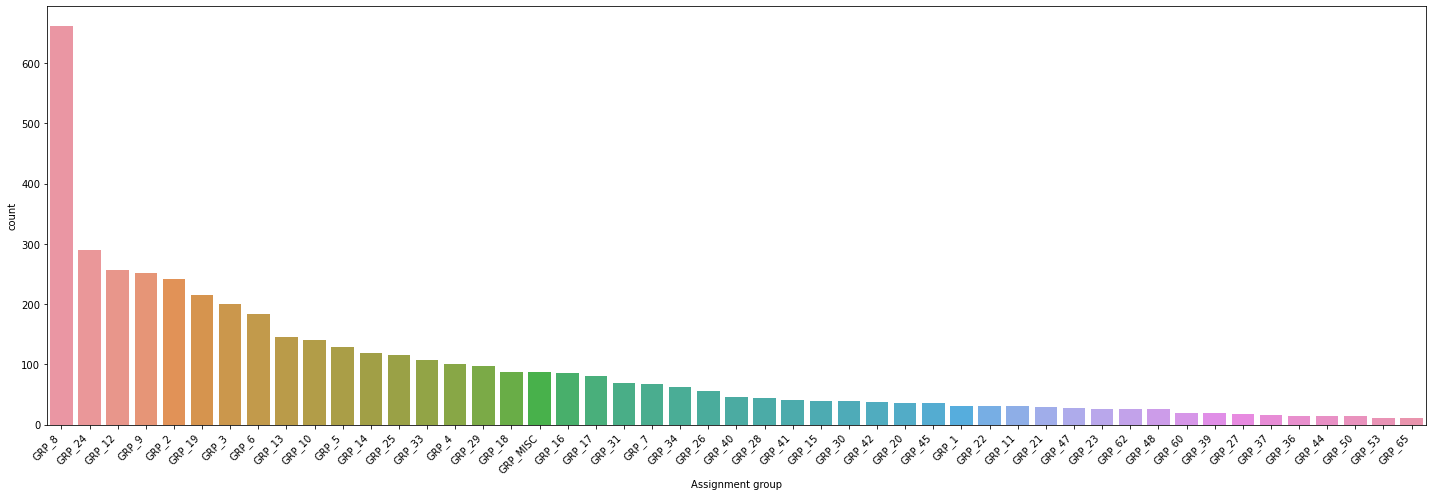

In [49]:
non_group0_df = clean_merged_df[clean_merged_df['Assignment group']!='GRP_0']
group_non0_vc = non_group0_df['Assignment group'].value_counts()
plt.figure(figsize=(20,7))
cplt = sns.countplot(non_group0_df['Assignment group'],order=group_non0_vc.sort_values(ascending=False).index)
cplt.set_xticklabels(cplt.get_xticklabels(), rotation=45, ha="right")
plt.tight_layout()
plt.show()

### Language
Let us investigate if the 'Language' variable may influence the assignment to the group.

In [50]:
clean_df[clean_df['Language']=='de']['Assignment group'].value_counts()

GRP_0     117
GRP_24    102
GRP_33     64
GRP_42     32
GRP_12     26
GRP_25     17
GRP_28      8
GRP_34      8
GRP_49      3
GRP_10      3
GRP_32      2
GRP_16      2
GRP_13      2
GRP_2       2
GRP_14      2
GRP_26      1
GRP_29      1
GRP_45      1
GRP_59      1
GRP_52      1
GRP_11      1
GRP_5       1
GRP_17      1
GRP_18      1
GRP_20      1
GRP_40      1
GRP_46      1
Name: Assignment group, dtype: int64

While group 24 and 12 are among the top 5 groups, groups 33, 42 and 25 are not. So it is worth considering the language as an input variable.

### Caller Variable
Let us investigate if the 'Caller' variable may influence the assignment to the group.

In [51]:
clean_merged_df['Caller'].value_counts()


bpctwhsn kzqsbmtp    810
ZkBogxib QsEJzdZO    151
fumkcsji sarmtlhy    134
rbozivdq gmlhrtvp     87
rkupnshb gsmzfojw     71
                    ... 
wmsaxylo tyqgpkxz      1
xbsckemt durnfyxb      1
dmlnpgkv ophsnmbr      1
bfgtnyow dahqfpns      1
uwlnpscr lvkujfse      1
Name: Caller, Length: 2950, dtype: int64

In [52]:
caller_count = pd.DataFrame(clean_merged_df['Caller'].value_counts())
caller_count.reset_index(inplace=True)
caller_count.columns=['Caller','Count']
caller_count.head()

Caller  Count
0  bpctwhsn kzqsbmtp    810
1  ZkBogxib QsEJzdZO    151
2  fumkcsji sarmtlhy    134
3  rbozivdq gmlhrtvp     87
4  rkupnshb gsmzfojw     71

In [53]:
caller_count.describe()

Count
count  2950.000000
mean      2.881356
std      15.847404
min       1.000000
25%       1.000000
50%       2.000000
75%       3.000000
max     810.000000

In [54]:
def caller_count_groups(caller):
    return len(clean_merged_df[clean_merged_df['Caller']==caller]['Assignment group'].unique())

caller_count['Groups'] = caller_count['Caller'].apply(caller_count_groups)

In [55]:
caller_count['Consider'] = (caller_count['Count'] > 10* caller_count['Groups'])
caller_count.head()


Caller  Count  Groups  Consider
0  bpctwhsn kzqsbmtp    810      16      True
1  ZkBogxib QsEJzdZO    151       9      True
2  fumkcsji sarmtlhy    134       3      True
3  rbozivdq gmlhrtvp     87       2      True
4  rkupnshb gsmzfojw     71      12     False

In [56]:
considered_callers = caller_count[caller_count['Consider']]['Caller']
#considered_callers.apply(lambda s: s.replace(' ',''))
considered_callers

0     bpctwhsn kzqsbmtp
1     ZkBogxib QsEJzdZO
2     fumkcsji sarmtlhy
3     rbozivdq gmlhrtvp
8     olckhmvx pcqobjnd
10    dkmcfreg anwmfvlg
11    efbwiadp dicafxhv
17    jionmpsf wnkpzcmv
28    niptbwdq csenjruz
45    qftpazns fxpnytmk
52    mdbegvct dbvichlg
60    wrcktgbd wzrgyunp
61    eqzibjhw ymebpoih
Name: Caller, dtype: object

From the above analysis, there are certain users whose tickets are being assigned to a very few groups, therefore, we will test to see if keeping their id will influence the results.

## Word Distribution
Let's view the distribution of words in the whole corpus and per group.

In [57]:
from wordcloud import WordCloud

def generate_wordcloud(words, name, max_w=20):
    wc = WordCloud(width=400, height=400, max_font_size=40, min_font_size=6, max_words=max_w, colormap='Set2',collocations=False).generate(words)
    plt.figure(figsize=(20,10))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title("Most common {} words of {}".format(max_w,name))
    plt.margins(x=0, y=0)
    plt.show()

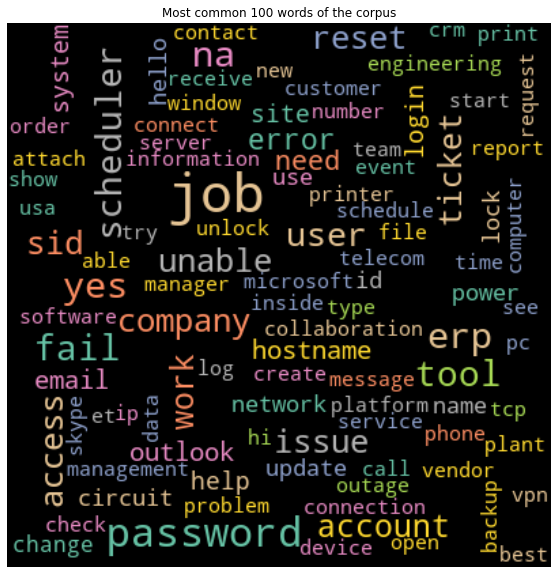

In [58]:
full_text = ' '.join(list(clean_merged_df['Description']))

generate_wordcloud(full_text, 'the corpus', 100)

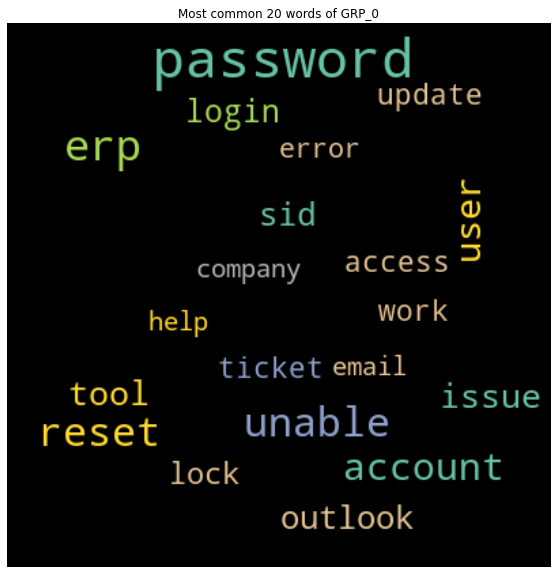

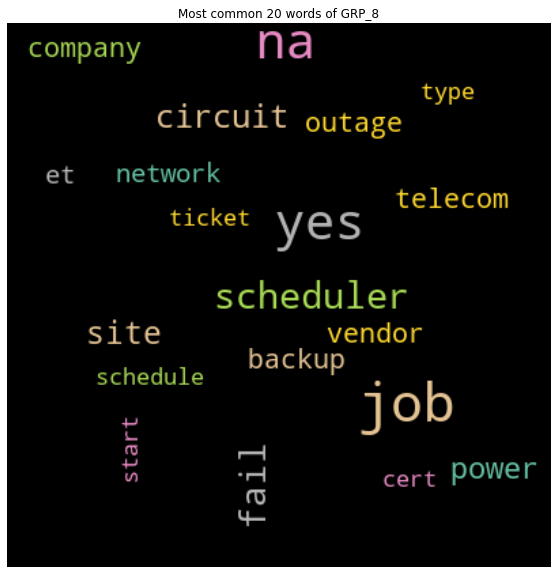

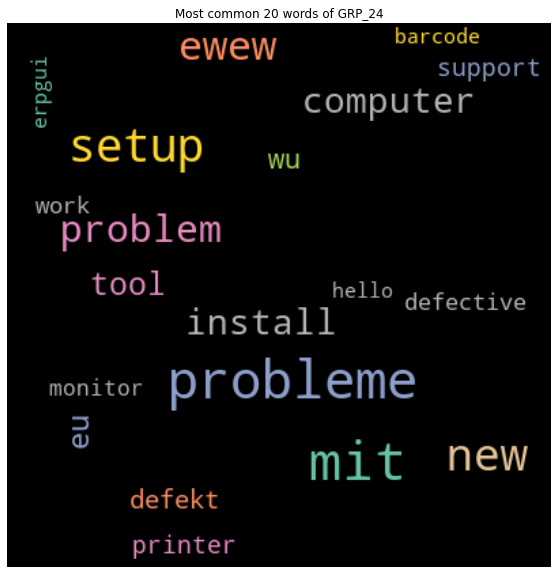

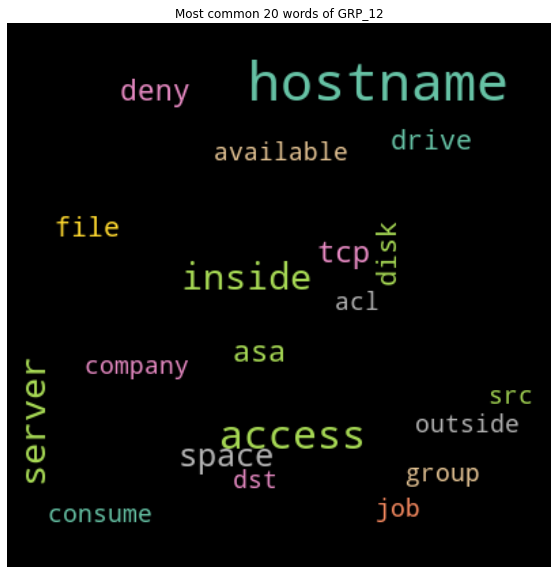

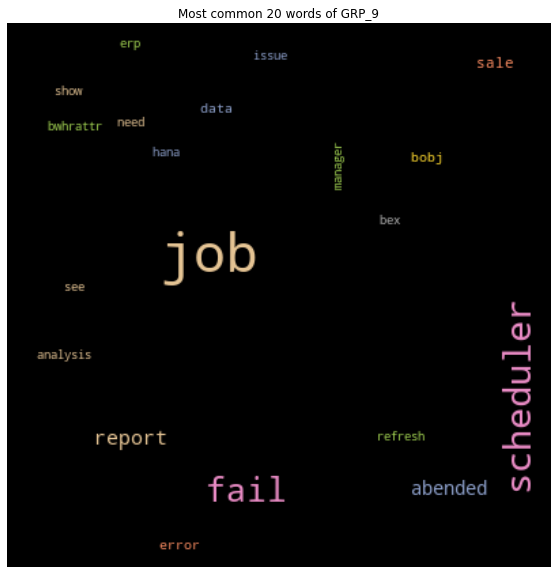

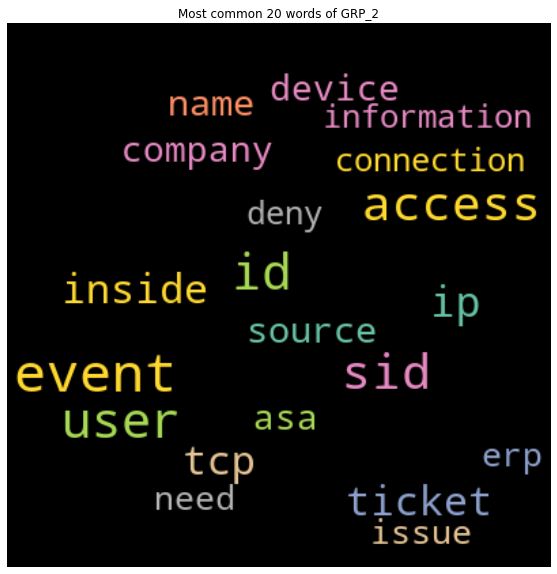

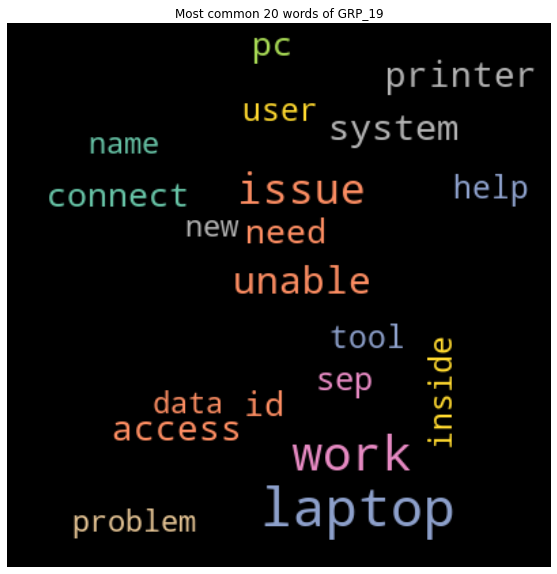

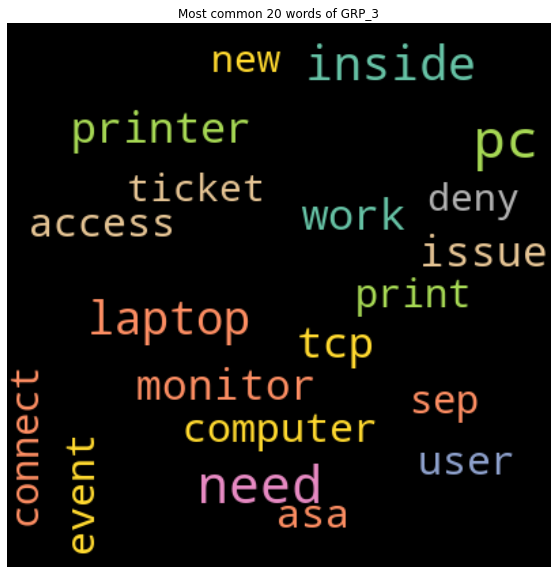

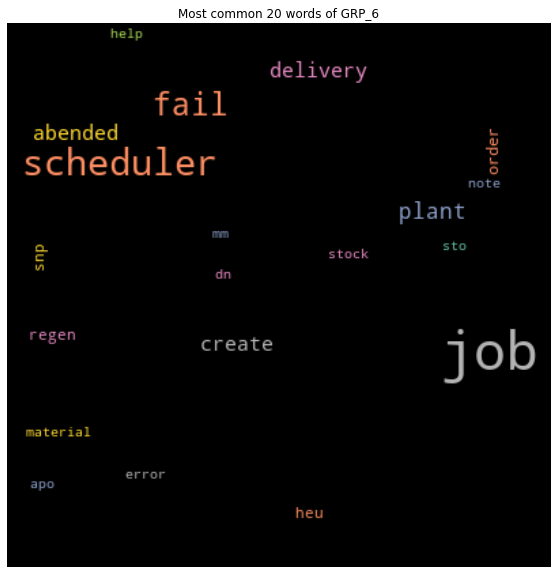

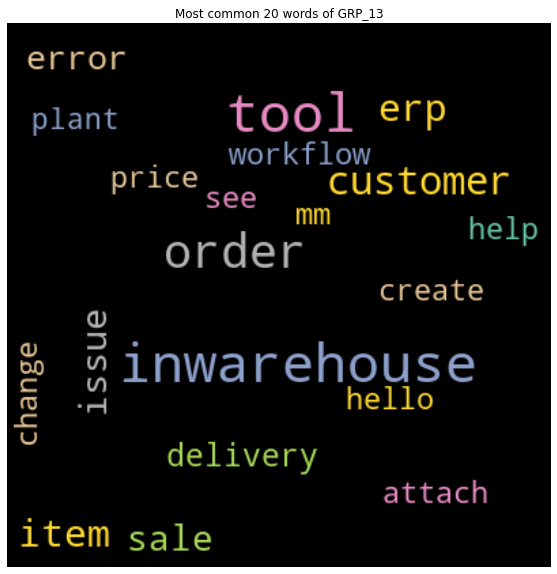

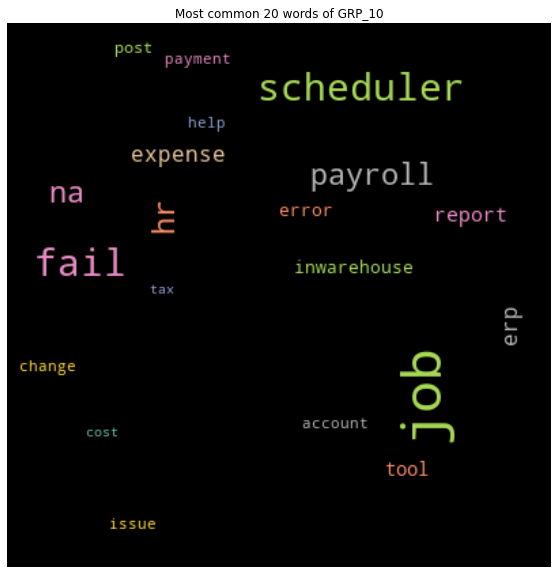

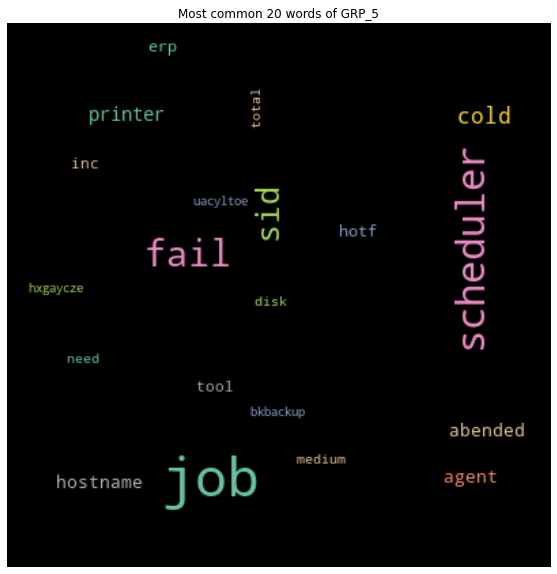

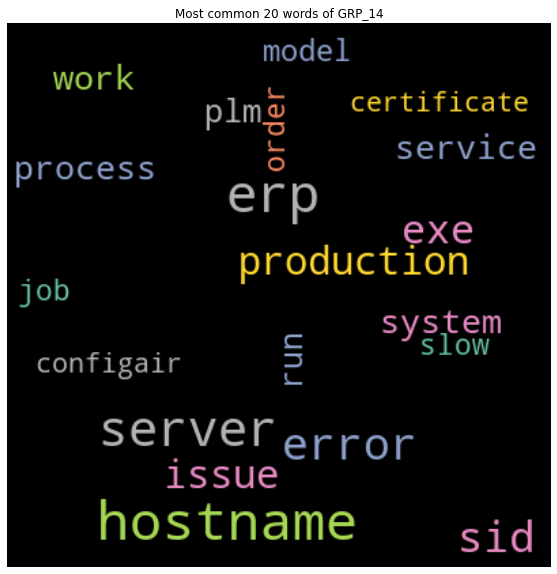

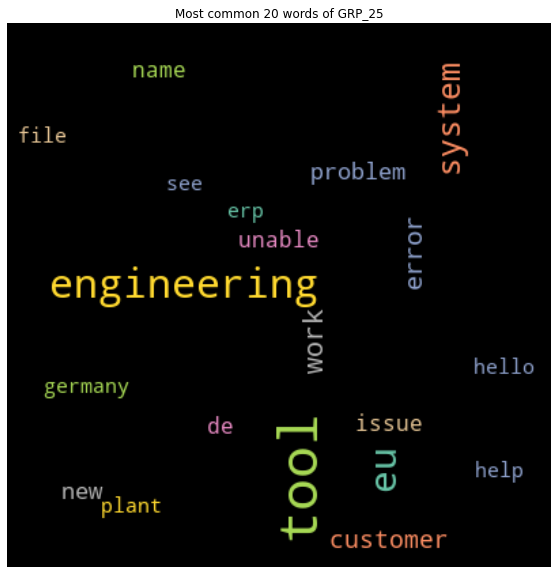

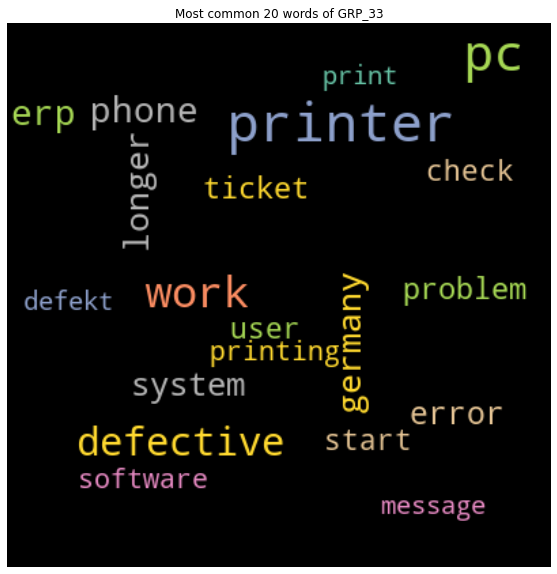

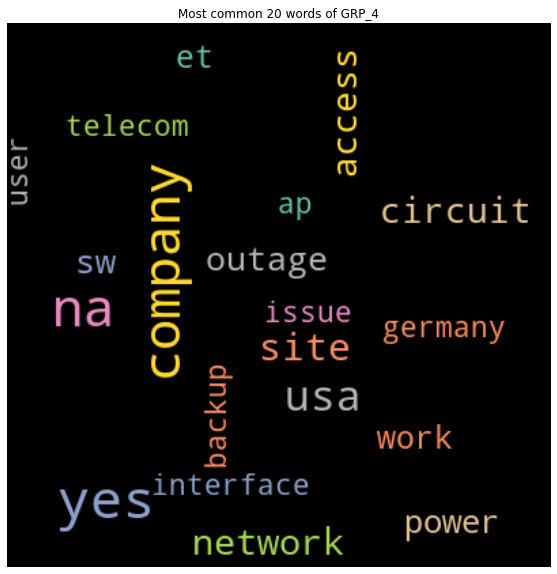

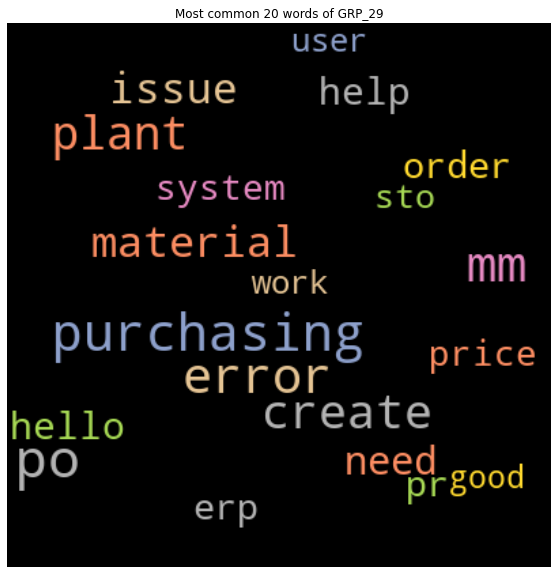

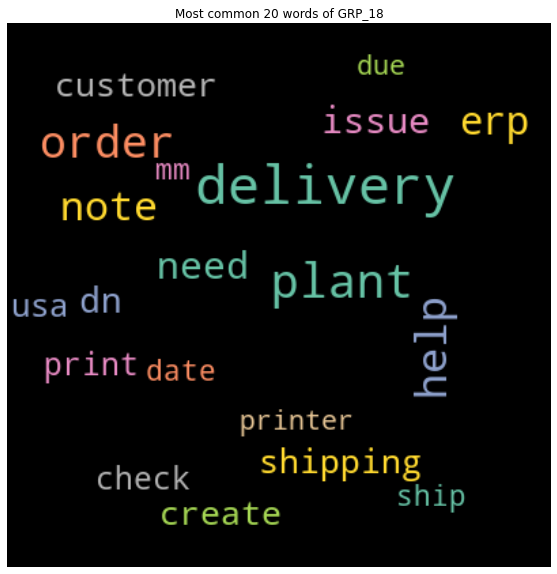

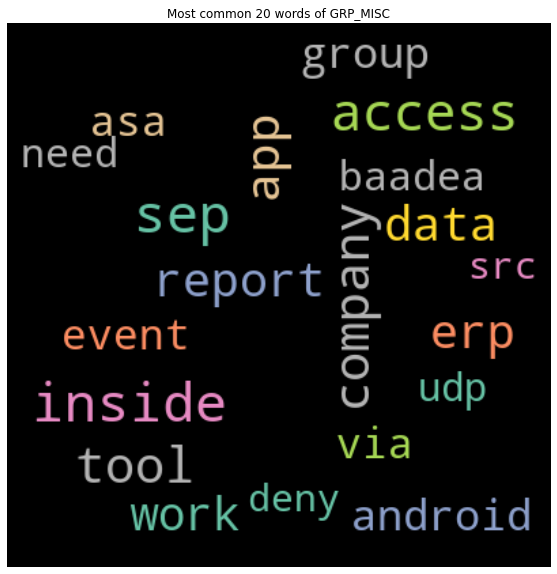

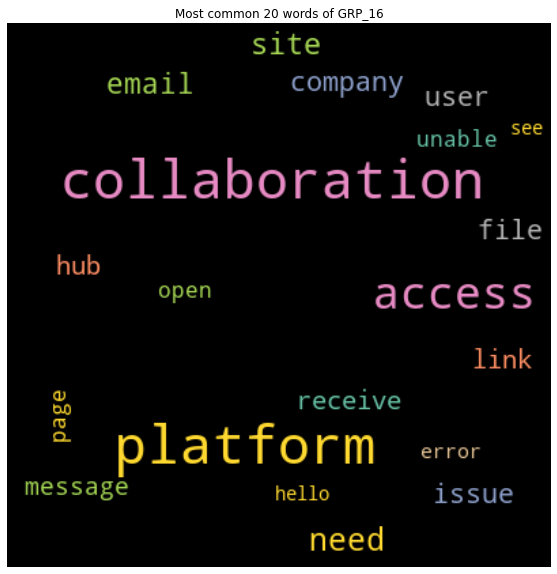

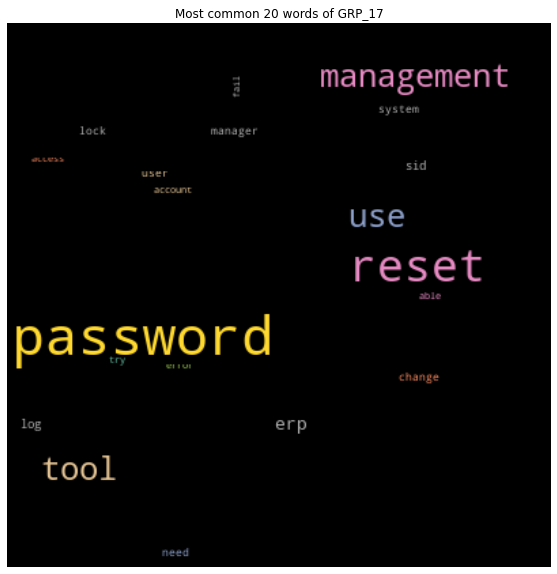

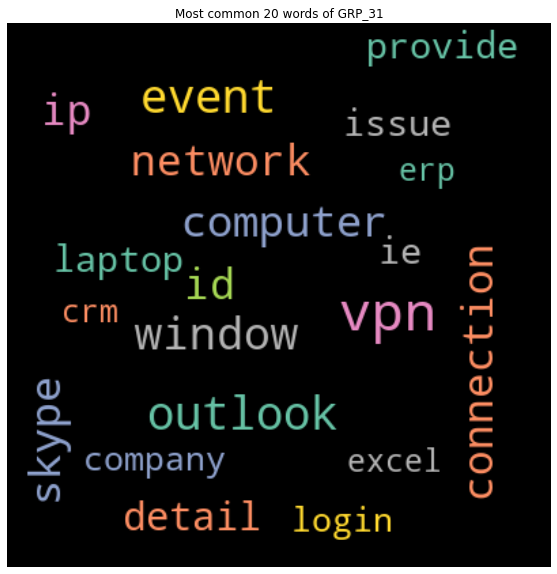

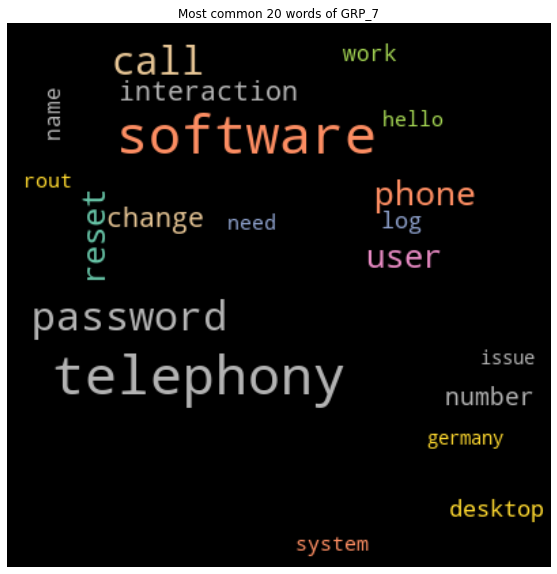

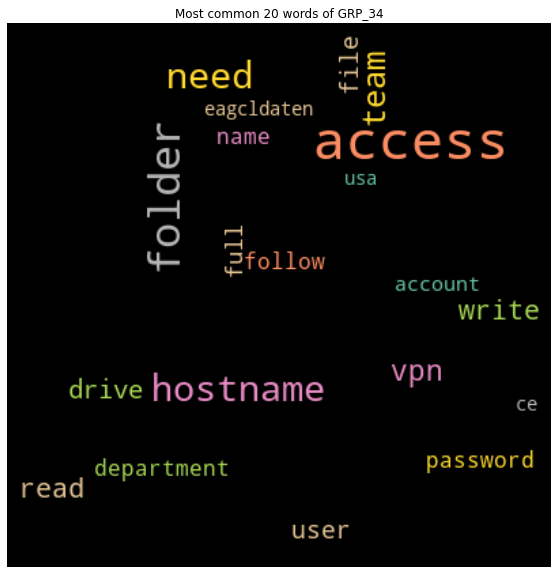

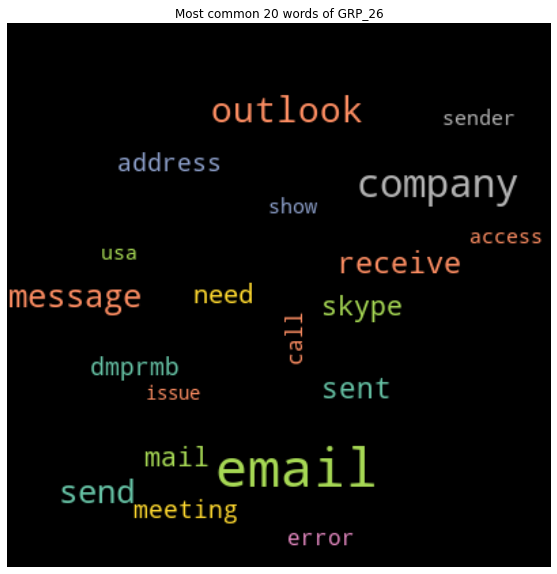

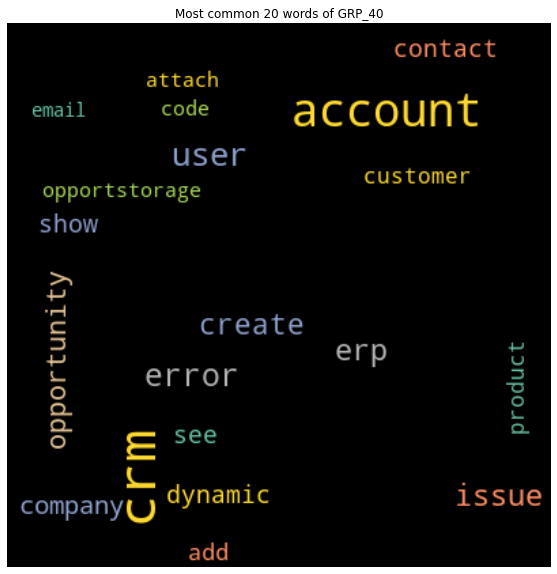

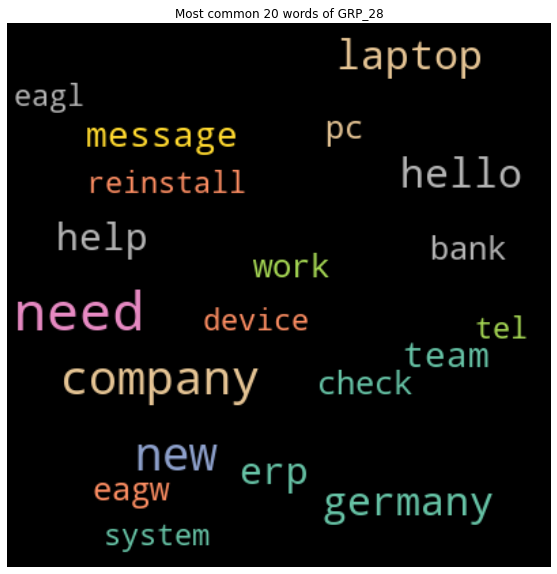

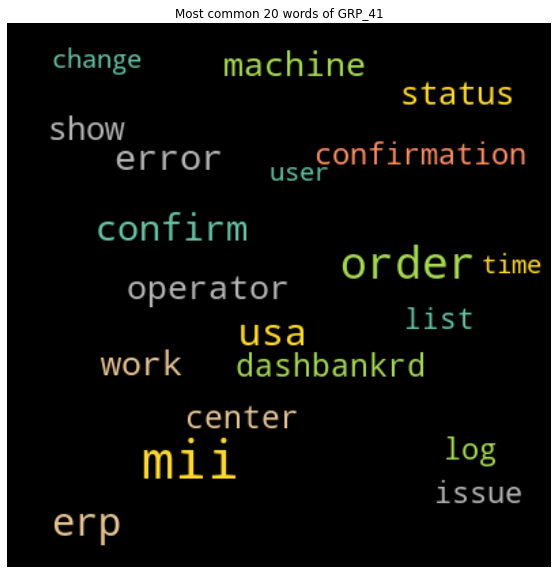

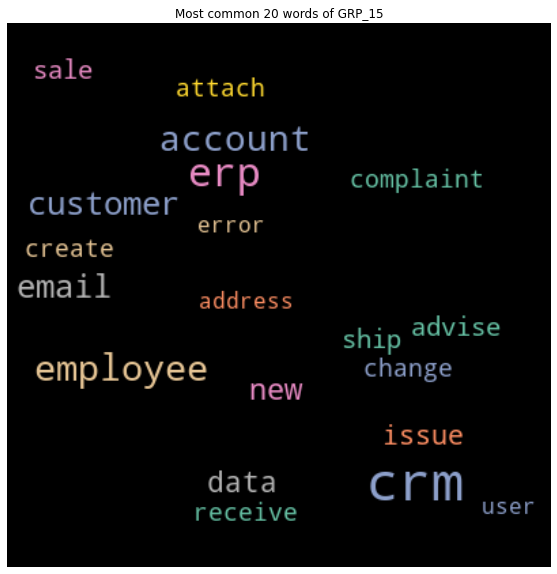

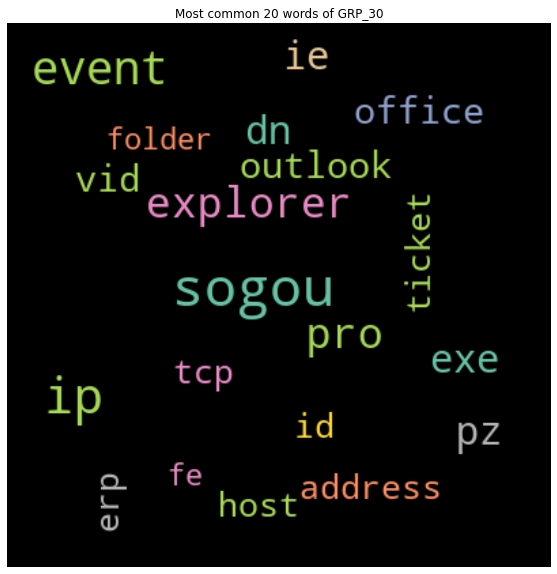

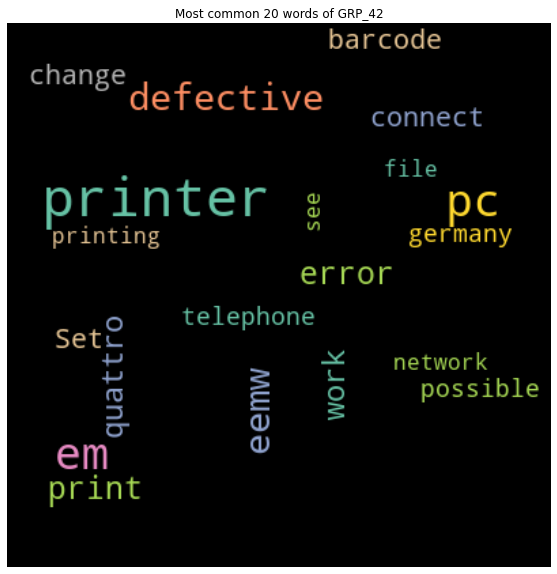

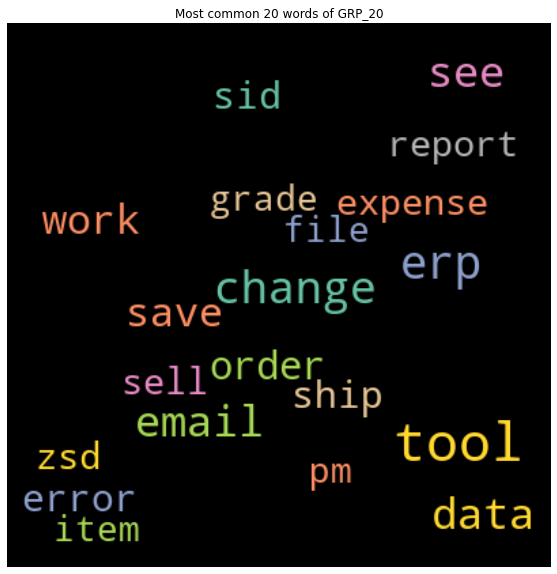

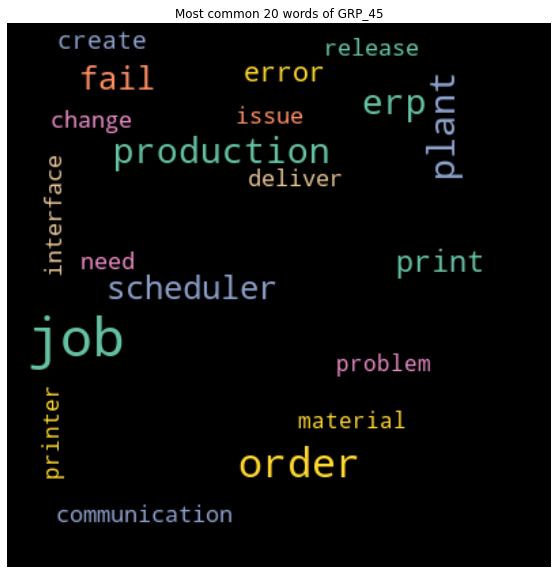

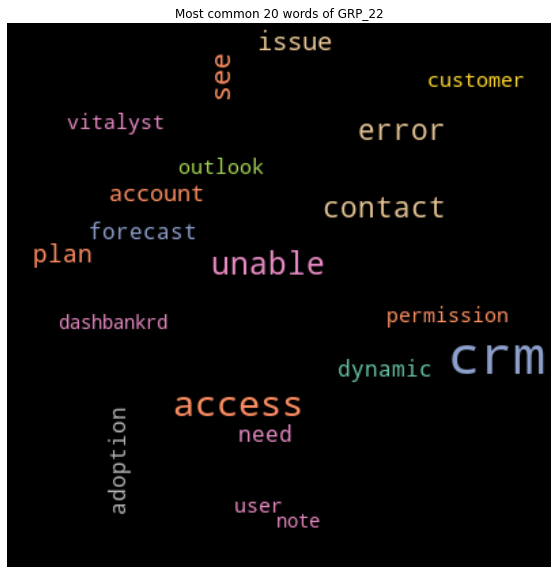

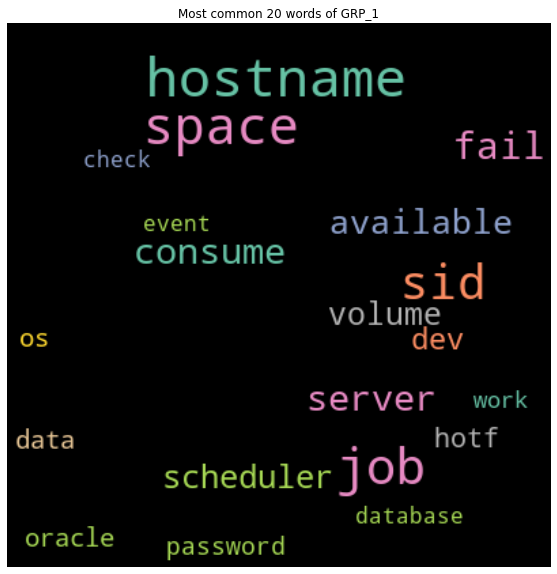

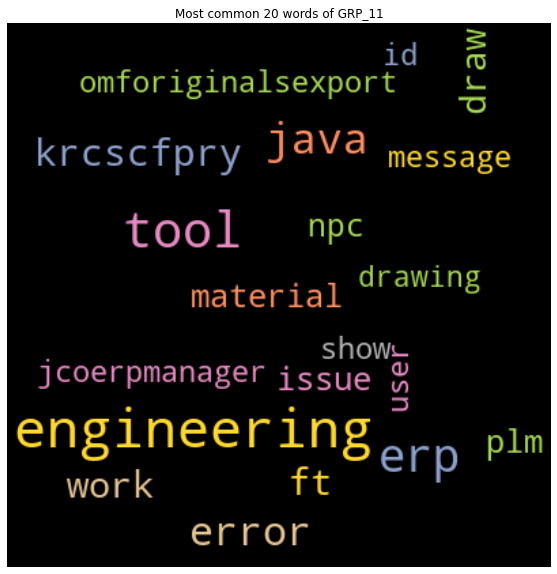

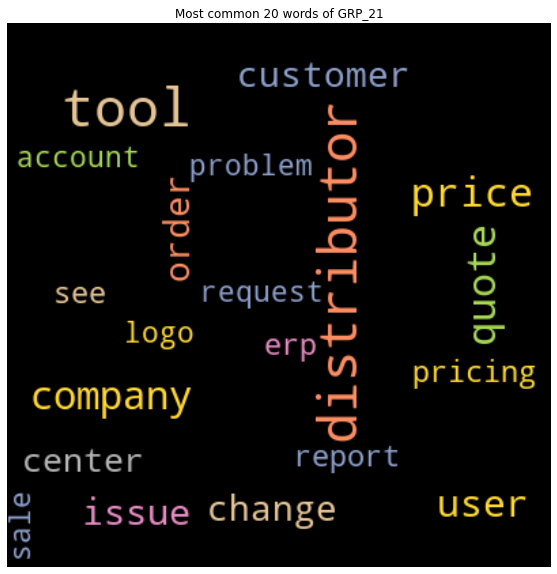

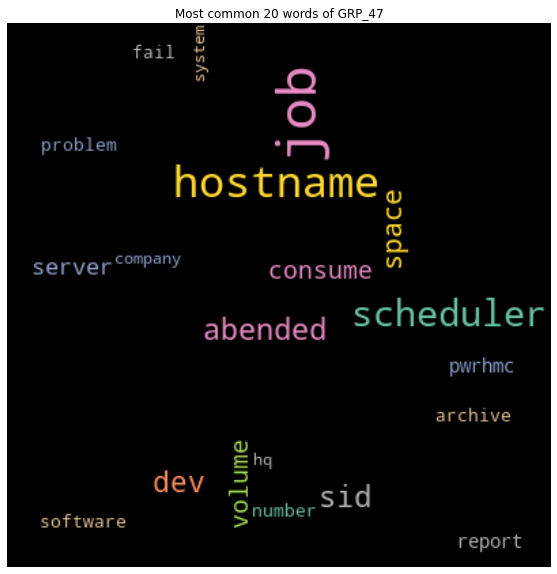

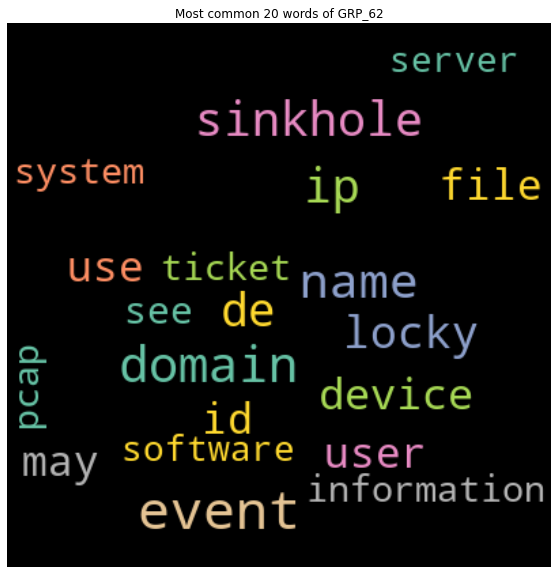

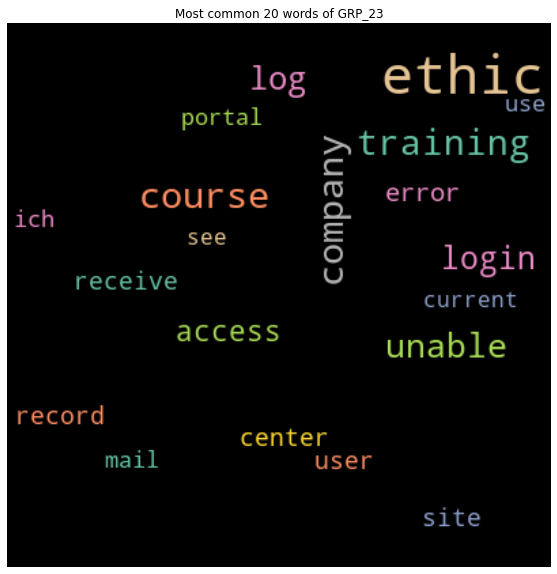

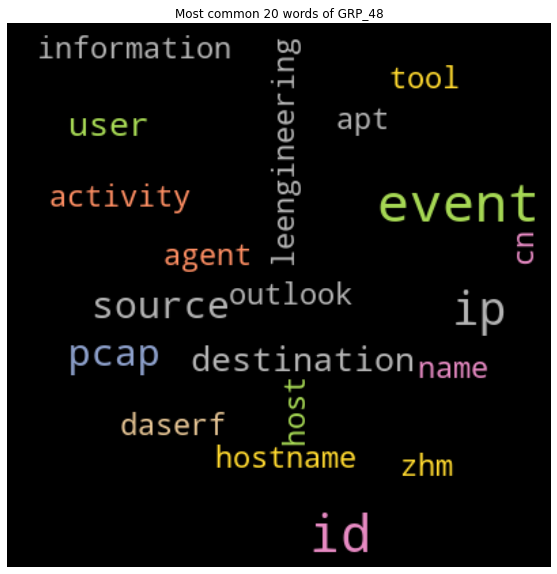

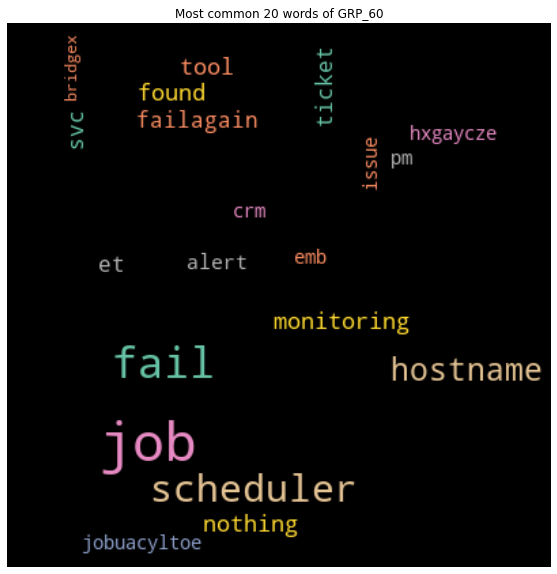

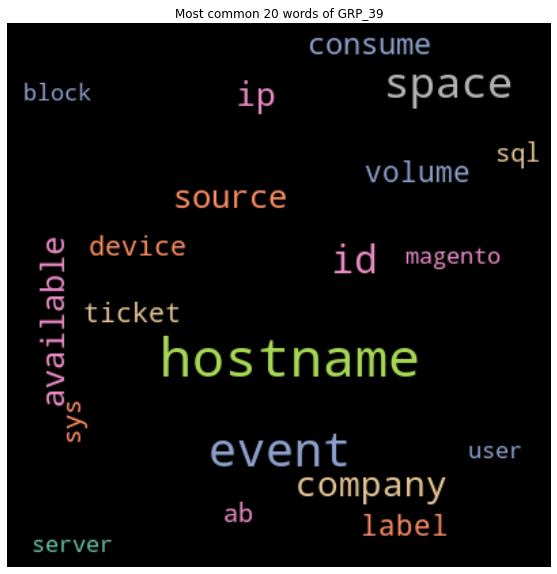

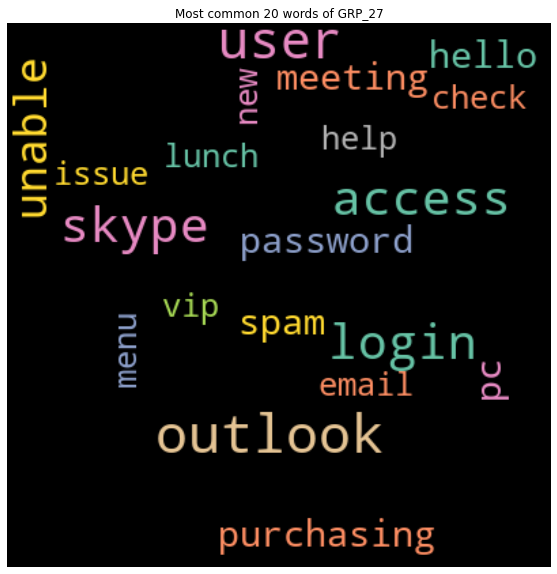

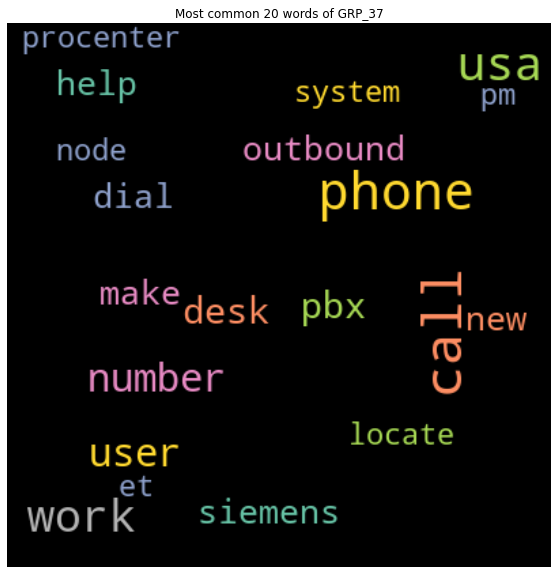

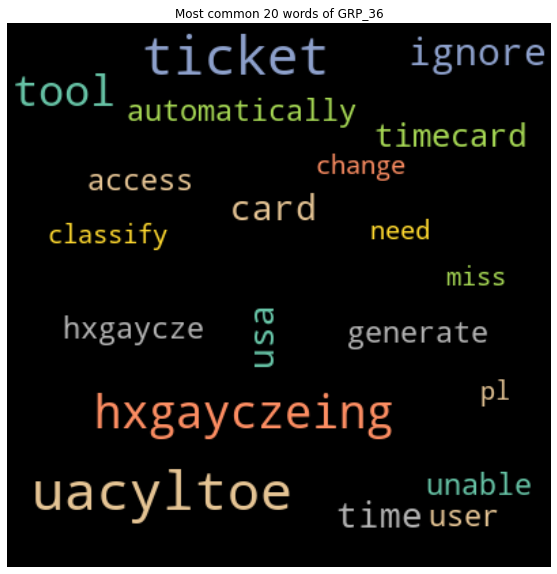

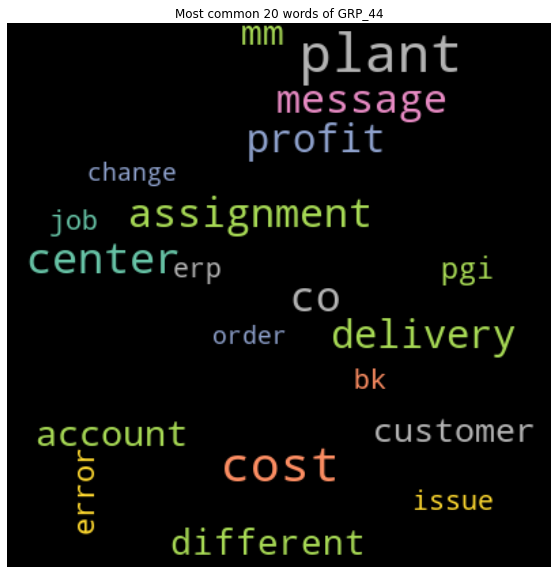

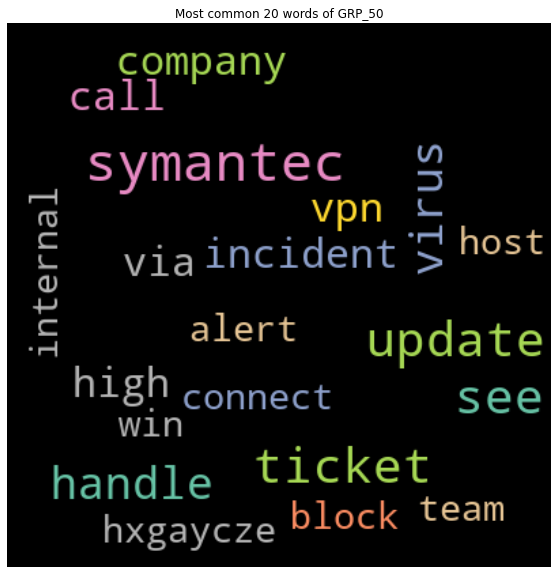

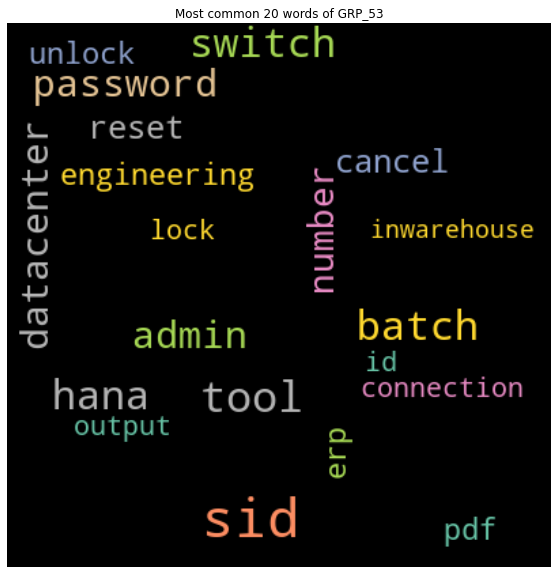

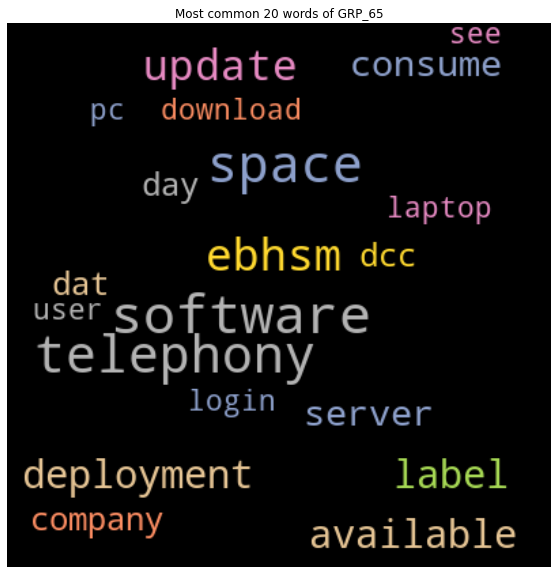

In [59]:
for i,x in enumerate(group_vc_new):
    group = group_vc_new.index[i]
    group_df = clean_merged_df[clean_merged_df ['Assignment group'] == group]
    group_texts = ' '.join(list(group_df['Description']))              
    generate_wordcloud(group_texts,group)

## Treat Imbalance

We will first investigate if there are any patterns in Group 0, so that this group can be broken down into smaller groups (either standalone or merged with other groups).

We will also try resampling the data so that each class is equally represented. 

### Group 0 Patterns

In [60]:
grp0_df = clean_merged_df[clean_merged_df['Assignment group']=='GRP_0']
grp0_len = grp0_df.shape[0]
second_max_count = group_non0_vc.max()
print('Group 0 size:', grp0_len)
print('Next biggest group (Group 8) size:', second_max_count)

Group 0 size: 3976
Next biggest group (Group 8) size: 661


In [61]:
import gensim
def get_tokens(dataframe):
    for i, desc in enumerate(dataframe['Description']):
        tokens = gensim.utils.simple_preprocess(desc)
        yield gensim.models.doc2vec.TaggedDocument(tokens, [i])

grp0_corpus = list(get_tokens(grp0_df))

In [62]:
doc2vec_model = gensim.models.doc2vec.Doc2Vec(vector_size=50, min_count=2, epochs=20)
doc2vec_model.build_vocab(grp0_corpus)
doc2vec_model.docvecs.most_similar([doc2vec_model.docvecs[0]])

[(0, 1.0),
 (2040, 0.4641590416431427),
 (169, 0.46092793345451355),
 (2248, 0.45688652992248535),
 (848, 0.43711572885513306),
 (3946, 0.4224452078342438),
 (1738, 0.4223056733608246),
 (3217, 0.4219941794872284),
 (2444, 0.4063054621219635),
 (1869, 0.40278860926628113)]

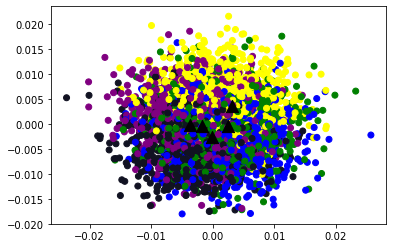

In [63]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA


doc2vec_kmeans_model = KMeans(n_clusters=5, init='k-means++', max_iter=100) 
grp0_X = doc2vec_kmeans_model.fit(doc2vec_model.docvecs.vectors_docs)
grp0_labels = doc2vec_kmeans_model.labels_.tolist()

l = doc2vec_kmeans_model.fit_predict(doc2vec_model.docvecs.vectors_docs)
pca = PCA(n_components=2).fit(doc2vec_model.docvecs.vectors_docs)
datapoint = pca.transform(doc2vec_model.docvecs.vectors_docs)

plt.figure
label1 = ['#FFFF00', '#008000', '#0000FF', '#800080', '#111222']
color = [label1[i] for i in grp0_labels]
plt.scatter(datapoint[:, 0], datapoint[:, 1], c=color)
centroids = doc2vec_kmeans_model.cluster_centers_
centroidpoint = pca.transform(centroids)
plt.scatter(centroidpoint[:, 0], centroidpoint[:, 1], marker='^', s=150, c='#000000')
plt.show()

As the clusters significantly overlap, we will not break down Group 0 (either as separate groups or to be merged with other similar groups). This suggests that most of the Group 0 tickets are very *similar* and that simply they are by nature the most frequent type of issue raised. Moreover, the similarity among the Group 0 ticket suggests that by downsampling this group we may not lose too much information. 

### Resample Assignment Groups
Next we will try resampling the data, so that Group 0 is downsampled to the next biggest size (that of Group 8) and the rest of the groups are upsampled to match that.

(33050, 4)


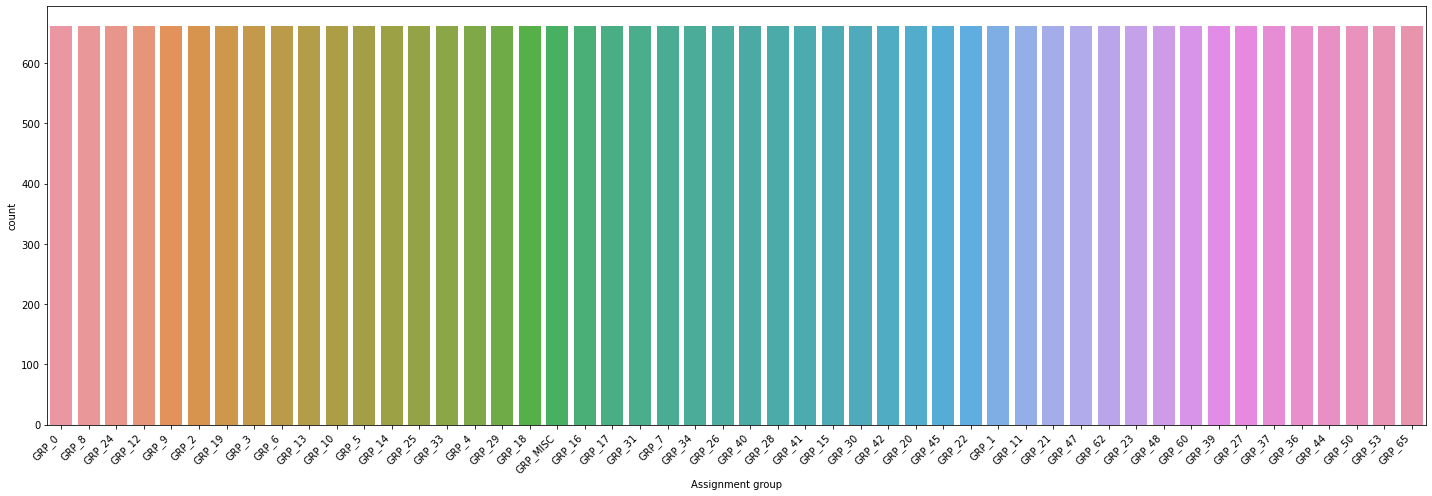

In [64]:
from sklearn.utils import resample

resampled_df = clean_merged_df[0:0]
for grp in group_vc_new.index:
    group_df = clean_merged_df[clean_merged_df['Assignment group'] == grp]
    resampled = resample(group_df, replace=True, n_samples=second_max_count, random_state=7)
    resampled_df = resampled_df.append(resampled)
    
print(resampled_df.shape)

plt.subplots(figsize=(20,7))
cplt=sns.countplot(x='Assignment group', data=resampled_df)
cplt.set_xticklabels(cplt.get_xticklabels(), rotation=45, ha="right")
plt.tight_layout()
plt.show()

In [65]:
resampled_df.to_excel('data_resampled_final.xlsx')

Next steps would be to convert the input to word embeddings and prepare the data for feeding into various models and compare the results. 

# Modelling

In [66]:
from gensim.models import Word2Vec
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, Flatten, Bidirectional, GlobalMaxPool1D,GRU,Conv1D,MaxPooling1D, TimeDistributed, Concatenate
from tensorflow.keras.models import Model, Sequential, load_model
import tensorflow as tf
from sklearn import metrics
from sklearn.metrics import multilabel_confusion_matrix,confusion_matrix
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model, to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from keras import optimizers
from gensim.models import FastText
from pprint import pprint
import seaborn as sns
import pandas as pd
import numpy as np


In [67]:
resampled_df = pd.read_excel('../input/ittickets/data_resampled.xlsx')
clean_df = pd.read_excel('../input/ittickets/cleaned_data_lem.xlsx')

In [68]:
from collections import OrderedDict

raw_data = clean_df.copy()
res_data = resampled_df.copy()

# remove duplicates
res_data['Description'] = res_data['Description'].astype(str).str.split().apply(lambda x:OrderedDict.fromkeys(x).keys()).str.join(' ')
raw_data['Description'] = raw_data['Description'].astype(str).str.split().apply(lambda x:OrderedDict.fromkeys(x).keys()).str.join(' ')


## Embedding and tokenisation

In [69]:
def get_w2v_model(desc_col,filename):
    sentences = [desc.split(' ') for desc in desc_col]
    w2v_model = Word2Vec(sentences=sentences,min_count=1)
    w2v_model.wv.save_word2vec_format(filename)
    
    return w2v_model

def get_ftxt_model(desc_col,filename):
    sentences = [desc.split(' ') for desc in desc_col]
    ftxt_model = FastText(sentences=sentences,size=100, min_count=5)
    ftxt_model.wv.save_word2vec_format(filename)
    
    return ftxt_model

def load_embedding(filename):
    w2v_embeddings = dict()
    f = open(filename)
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        w2v_embeddings[word] = coefs
    f.close()
    
    return w2v_embeddings

def get_embedding(model):
    w2v_embeddings = dict()
    for word in model.wv.vocab:
        w2v_embeddings[word] = model.wv[word]
    return w2v_embeddings

In [70]:
def tokenize_and_embed(desc_col, maxlen, embeddings):
    tokenizer = Tokenizer(num_words=len(embeddings), split=' ')
    tokenizer.fit_on_texts(desc_col.values)
    num_words = len(tokenizer.word_index)
    
    X = tokenizer.texts_to_sequences(desc_col)
    X = pad_sequences(X, maxlen = maxlen)
    
    embedding_matrix = np.zeros((num_words+1, 100))
    for word, i in tokenizer.word_index.items():
        embedding_vector = embeddings.get(word)
        if embedding_vector is not None:
            embedding_matrix[i-1] = embedding_vector

    return X, embedding_matrix


## Model Creation, Metrics and Plots

In [71]:
# Create and fit sequential LSTM model
def create_LSTM_model(maxlen,num_words,embedding_matrix,num_categories,opt):    
    model = Sequential()
    model.add(Embedding(num_words,output_dim=100,input_length=maxlen, weights = [embedding_matrix], trainable=True))
    model.add(Bidirectional(LSTM(128)))#, dropout=0.2, recurrent_dropout=0.2)))
    model.add(Dropout(0.3))
    model.add(Dense(128,activation='relu'))
    model.add(Dense(128,activation='relu'))
    model.add(Dense(num_categories, activation='softmax'))

    model.compile(loss='sparse_categorical_crossentropy',optimizer=opt,metrics=['accuracy'])

    model.summary()
    return model

def fit_model(model, X_train, y_train, X_val, y_val, batch_size, epochs):
    checkpoint = ModelCheckpoint('model-{epoch:03d}-{val_accuracy:03f}.h5', verbose=1, monitor='val_accuracy',save_best_only=True, mode='auto') 
    reduceLoss = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001)
    model_history = model.fit(X_train,y_train,batch_size=batch_size, epochs=epochs, callbacks=[checkpoint,reduceLoss], validation_data=(X_val,y_val))
              
    return model_history

In [72]:
# Plot model accuracy
def plot_accuracy(history, name):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])

    plt.title(name + ' model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train','test'], loc='upper left')
    plt.show()

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])

    plt.title(name +' model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train','test'], loc='upper left')
    plt.show()

In [73]:
# Get model predictions, metrics and confusion matrices
def get_pred_metrics(model, X_test, y_test, grp_mapping, plotcm=False):      
    preds = model.predict(X_test)
    pred = [p.argmax() for p in preds]
    
    accuracy = metrics.accuracy_score(y_test, pred)
    f1_score = metrics.f1_score(y_test, pred, average='weighted')
    #print("Accuracy:", accuracy)
    #print("F1_score:", f1_score)

    if plotcm:
        cm = confusion_matrix(y_test, pred)    
        plt.figure(figsize=(80,80))
        cmplt = sns.heatmap(cm,annot=True,fmt="d")
        plt.show()

        mcms = multilabel_confusion_matrix(y_test, pred)
        for i,mcm in enumerate(mcms):
            plt.figure(figsize=(2,2))
            cmplt = sns.heatmap(mcm,annot=True,fmt="d")
            plt.title(grp_mapping[i])
            plt.show()

            #plt.figure(figsize=(2,2))
            #cmplt = sns.heatmap(cm[i].flatten(),annot=True,fmt="d")
            #plt.title(grp_mapping[i])
            #plt.show()
        
    return accuracy, f1_score, pred

In [74]:
def run_model(data, model_name, data_desc, emb_name, batch_size=100, epochs=15, opt='adam', lr=0.001, plotcm=False, random_state=7):
    run_name = model_name + "_" + data_desc+ "_" + emb_name + "_" + opt + "(LR=" + str(lr) + ")"
    
    # get embedding
    if emb_name == 'ftxt':
        emb_model = get_ftxt_model(data['Description'],run_name)
        embedding = get_embedding(emb_model)
    elif emb_name == 'glv':
        embedding = load_embedding('../input/ittickets/glove.6B.100d.txt')
    else:
        emb_model = get_w2v_model(data['Description'],run_name)
        embedding = get_embedding(emb_model)
        
    maxlen = 300
    
    X, embedding_matrix = tokenize_and_embed(data['Description'],maxlen, embedding)
    
    y = data['Assignment group']
    label_encoder = LabelEncoder() 
    y = label_encoder.fit_transform(y)
    grp_mapping = dict(zip(label_encoder.transform(label_encoder.classes_), label_encoder.classes_))
    
    X_train, X_val, y_train, y_val = train_test_split(X,y,random_state = 7,test_size=0.2)
    X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, random_state = 7, test_size=0.2)
    
    
    num_words = embedding_matrix.shape[0]
    batch_size = batch_size
    epochs = epochs
    num_categories = len(data['Assignment group'].unique())
    
    if opt == 'rmsprop':
        optim = optimizers.RMSprop(lr)
    elif opt == 'sgd':
        optim = optimizers.SGD(lr)
    elif opt == 'adagrad':
        optim = optimizers.Adagrad(lr)
    else:
        optim = optimizers.Adam(lr)
    
    if model_name == 'LSTM':
        model = create_LSTM_model(maxlen,num_words,embedding_matrix, num_categories, optim)
    elif model_name == 'GRU':
        model = create_GRU_model(maxlen,num_words,embedding_matrix, num_categories, optim)
    elif model_name == 'DRNN':
        model = create_DRNN_model(maxlen,num_words,embedding_matrix, num_categories, optim)

    history = fit_model(model, X_train, y_train, X_val, y_val, batch_size, epochs)
    
    # Save the run
    model.save(run_name + '_model.h5')
    model.save_weights(run_name + '_weights.h5')
    model_json = model.to_json()
    with open(run_name + '_model.json', 'w') as json_file:
        json_file.write(model_json)
    history_df = pd.DataFrame(history.history)
    with open(run_name + '_history.json', 'w') as hist_json_file:
        history_df.to_json(hist_json_file)
       
    # Plot training and validation accuracy
    plot_accuracy(history,run_name)
    
    # Get predictions and results
    accuracy, f1_score, test_pred = get_pred_metrics(model,X_test, y_test, grp_mapping, plotcm)
    
    return model, run_name, history, accuracy, f1_score, test_pred

In [75]:
results = pd.DataFrame(
      {'description':[], 
      'val_accuracy': [],
      'val_loss':[],
      'training_accuracy':[],
      'training_loss':[],
      'test_accuracy': [],
      'test_f1_score': []})

def update_results(run_name, history, accuracy, f1_score):
    best_index = np.argmax(history.history['val_accuracy'])
    run_result = pd.DataFrame(
      { 'description':[run_name],
      'val_accuracy': [history.history['val_accuracy'][best_index]],
      'val_loss':[history.history['val_loss'][best_index]],
      'training_accuracy':[history.history['accuracy'][best_index]],
      'training_loss':[history.history['loss'][best_index]],
      'test_accuracy': [accuracy],
      'test_f1_score': [f1_score]
      })
                            
    return results.append(run_result, ignore_index=True)

### Model 1: LSTM with (almost) raw data
Raw data with minority groups merged.

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/layers/recurrent.py:820: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  if (isinstance(inputs, collections.Sequence)


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 300, 100)          1025200   
_________________________________________________________________
bidirectional (Bidirectional (None, 256)               234496    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               32896     
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_2 (Dense)              (None, 74)                9546      
Total params: 1,318,650
Trainable params: 1,318,650
Non-trainable params: 0
______________________________________________

/opt/conda/lib/python3.7/site-packages/tensorflow/python/training/tracking/data_structures.py:718: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  if not isinstance(wrapped_dict, collections.Mapping):


54/55 [============================>.] - ETA: 0s - loss: 2.6711 - accuracy: 0.4646
Epoch 00001: val_accuracy improved from -inf to 0.47000, saving model to model-001-0.470000.h5
55/55 [==============================] - 4s 77ms/step - loss: 2.6696 - accuracy: 0.4642 - val_loss: 2.4186 - val_accuracy: 0.4700 - lr: 0.0010
Epoch 2/20
54/55 [============================>.] - ETA: 0s - loss: 2.2449 - accuracy: 0.5174
Epoch 00002: val_accuracy improved from 0.47000 to 0.52706, saving model to model-002-0.527059.h5
55/55 [==============================] - 3s 63ms/step - loss: 2.2441 - accuracy: 0.5178 - val_loss: 2.1702 - val_accuracy: 0.5271 - lr: 0.0010
Epoch 3/20
54/55 [============================>.] - ETA: 0s - loss: 2.0243 - accuracy: 0.5487
Epoch 00003: val_accuracy improved from 0.52706 to 0.53941, saving model to model-003-0.539412.h5
55/55 [==============================] - 4s 64ms/step - loss: 2.0275 - accuracy: 0.5483 - val_loss: 2.0750 - val_accuracy: 0.5394 - lr: 0.0010
Epoch 4/2

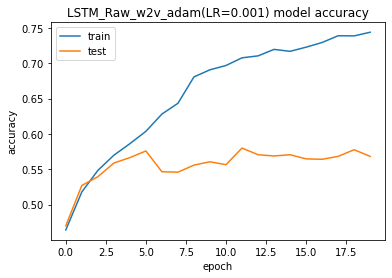

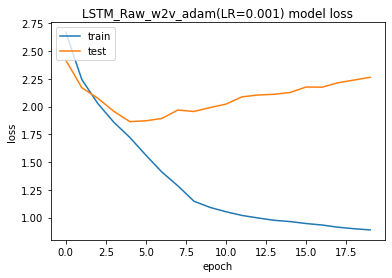

description  val_accuracy  val_loss  training_accuracy  \
0  LSTM_Raw_w2v_adam(LR=0.001)          0.58  2.087598           0.707721   

   training_loss  test_accuracy  test_f1_score  
0       1.019307       0.547794        0.51714

In [76]:
model, run_name, history, accuracy, f1_score, test_pred = run_model(raw_data, 'LSTM', 'Raw', 'w2v', 100, 20)
results = update_results(run_name, history, accuracy, f1_score)
results

### Model 2: LSTM with resampled data

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 300, 100)          861800    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               234496    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_4 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_5 (Dense)              (None, 50)                6450      
Total params: 1,152,154
Trainable params: 1,152,154
Non-trainable params: 0
____________________________________________

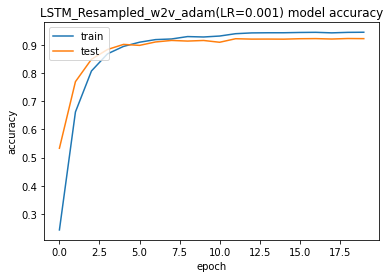

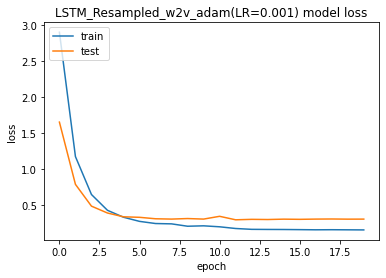

description  val_accuracy  val_loss  \
0        LSTM_Raw_w2v_adam(LR=0.001)       0.58000  2.087598   
1  LSTM_Resampled_w2v_adam(LR=0.001)       0.92239  0.303842   

   training_accuracy  training_loss  test_accuracy  test_f1_score  
0           0.707721       1.019307       0.547794       0.517140  
1           0.944213       0.155587       0.921331       0.922836

In [77]:
model, run_name, history, accuracy, f1_score, test_pred = run_model(res_data, 'LSTM', 'Resampled', 'w2v', 100, 20)
results = update_results(run_name, history, accuracy, f1_score)
results

#### Model 3: LSTM with resampled data and additional input variables

In [78]:
def create_LSTM_model_with_vars(maxlen,num_words,embedding_matrix,num_categories,num_vars, opt):    
    text_input = Input(shape=(maxlen,)) 
    meta_input = Input(shape=(num_vars,))
    embed = Embedding(num_words,output_dim=100,input_length=maxlen,weights=[embedding_matrix], trainable=True)(text_input) 
    lstm = Bidirectional(LSTM(128))(embed)
    drop = Dropout(0.3)(lstm)
    concat = Concatenate([drop, meta_input]) 
    classifier = Dense(32, activation='relu')(drop) 
    output = Dense(num_categories,activation='softmax')(classifier) 
    model = Model(inputs=[text_input , meta_input], outputs=output)
    #model = Model(input_layer,out)
    model.compile(loss='sparse_categorical_crossentropy',optimizer=opt,metrics=['accuracy'])

    model.summary()
    return model



In [79]:
run_name = "LSTM_Resampled_w2v_adam(LR=0.001)"


In [80]:
emb_model = get_w2v_model(res_data['Description'],run_name)
embedding = get_embedding(emb_model)
        
maxlen = 300
    
X, embedding_matrix = tokenize_and_embed(res_data['Description'],maxlen, embedding)
    
y = res_data['Assignment group']
label_encoder = LabelEncoder() 
y = label_encoder.fit_transform(y)
grp_mapping = dict(zip(label_encoder.transform(label_encoder.classes_), label_encoder.classes_))
    
X_train, X_val, y_train, y_val = train_test_split(X,y,random_state = 7,test_size=0.2)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, random_state = 7, test_size=0.2)
    

In [81]:
label_encoder = LabelEncoder() 
callers_x = res_data['Caller']
callers_x = label_encoder.fit_transform(callers_x)
callers_mapping = dict(zip(label_encoder.transform(label_encoder.classes_), label_encoder.classes_))
callers_x.shape

lang_x = (res_data['Language']!='en').astype(int)

In [82]:
res_caller_X_train, res_caller_X_val = train_test_split(callers_x,random_state = 7,test_size=0.2)
res_lang_X_train, res_langr_X_val = train_test_split(lang_x,random_state = 7,test_size=0.2)
res_caller_X_train, res_caller_X_test = train_test_split(res_caller_X_train,random_state = 7,test_size=0.2)
res_lang_X_train, res_langr_X_test = train_test_split(res_lang_X_train,random_state = 7,test_size=0.2)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 300)]        0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 300, 100)     861800      input_1[0][0]                    
__________________________________________________________________________________________________
bidirectional_2 (Bidirectional) (None, 256)          234496      embedding_2[0][0]                
__________________________________________________________________________________________________
dropout_2 (Dropout)             (None, 256)          0           bidirectional_2[0][0]            
______________________________________________________________________________________________

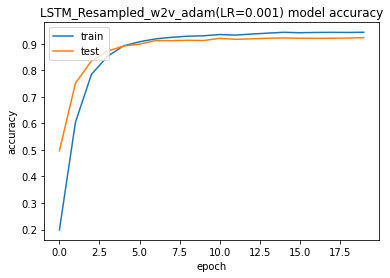

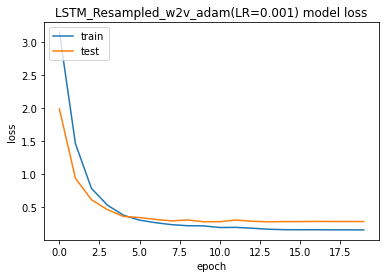

description  val_accuracy  val_loss  \
0        LSTM_Raw_w2v_adam(LR=0.001)      0.580000  2.087598   
1  LSTM_Resampled_w2v_adam(LR=0.001)      0.922390  0.303842   
2  LSTM_Resampled_w2v_adam(LR=0.001)      0.922995  0.287431   

   training_accuracy  training_loss  test_accuracy  test_f1_score  
0           0.707721       1.019307       0.547794       0.517140  
1           0.944213       0.155587       0.921331       0.922836  
2           0.943173       0.160881       0.922088       0.923463

In [83]:
num_words = embedding_matrix.shape[0]
batch_size = 100
num_categories = len(res_data['Assignment group'].unique())
epochs = 20
optim = optimizers.Adam(0.001)

model = create_LSTM_model_with_vars(maxlen,num_words,embedding_matrix, num_categories, 2, optim)
history = fit_model(model, [X_train,[res_caller_X_train,res_lang_X_train]], y_train, [X_val,[res_caller_X_val,res_langr_X_val]],y_val, batch_size, epochs)


model.save(run_name + '_model.h5')
model.save_weights(run_name + '_weights.h5')
model_json = model.to_json()
with open(run_name + '_model.json', 'w') as json_file:
    json_file.write(model_json)
history_df = pd.DataFrame(history.history)
with open(run_name + '_history.json', 'w') as hist_json_file:
    history_df.to_json(hist_json_file)
       
# Plot training and validation accuracy
plot_accuracy(history,run_name)
    
# Get predictions and results
accuracy, f1_score, test_pred = get_pred_metrics(model,X_test, y_test, grp_mapping, False)
    
results = update_results(run_name, history, accuracy, f1_score)
results

Resampling the data has played an its vital role in obtaining better results (92% accuracy). Adding additional input variables has not achieved much beyond that, therefore, going forward we can leave them out in favor of simplicity of the models and their efficiency. 

### Model 4: LSTM with resampled data and Glove embedding

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 300, 100)          861800    
_________________________________________________________________
bidirectional_3 (Bidirection (None, 256)               234496    
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_9 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_10 (Dense)             (None, 50)                6450      
Total params: 1,152,154
Trainable params: 1,152,154
Non-trainable params: 0
____________________________________________

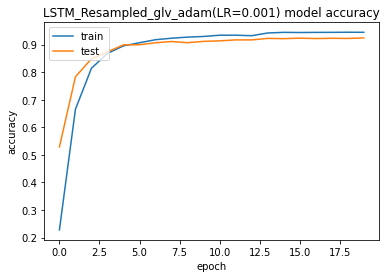

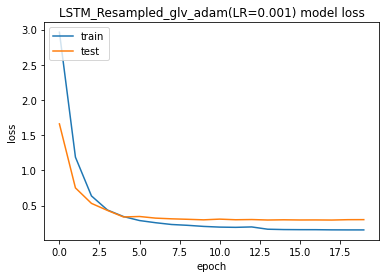

description  val_accuracy  val_loss  \
0        LSTM_Raw_w2v_adam(LR=0.001)      0.580000  2.087598   
1  LSTM_Resampled_w2v_adam(LR=0.001)      0.922390  0.303842   
2  LSTM_Resampled_w2v_adam(LR=0.001)      0.922995  0.287431   
3  LSTM_Resampled_glv_adam(LR=0.001)      0.924206  0.299497   

   training_accuracy  training_loss  test_accuracy  test_f1_score  
0           0.707721       1.019307       0.547794       0.517140  
1           0.944213       0.155587       0.921331       0.922836  
2           0.943173       0.160881       0.922088       0.923463  
3           0.944733       0.153596       0.920008       0.921391

In [84]:
model, run_name, history, accuracy, f1_score, test_pred = run_model(res_data, 'LSTM', 'Resampled', 'glv', 100, 20)
results = update_results(run_name, history, accuracy, f1_score)
results

### Model 4: LSTM with resampled data and FastText embedding

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 300, 100)          861800    
_________________________________________________________________
bidirectional_4 (Bidirection (None, 256)               234496    
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_12 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_13 (Dense)             (None, 50)                6450      
Total params: 1,152,154
Trainable params: 1,152,154
Non-trainable params: 0
____________________________________________

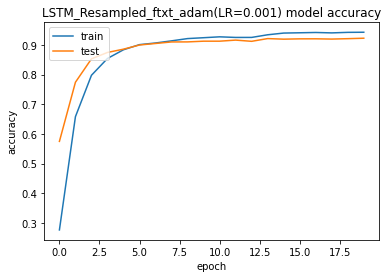

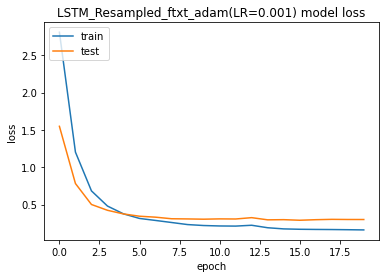

description  val_accuracy  val_loss  \
0         LSTM_Raw_w2v_adam(LR=0.001)      0.580000  2.087598   
1   LSTM_Resampled_w2v_adam(LR=0.001)      0.922390  0.303842   
2   LSTM_Resampled_w2v_adam(LR=0.001)      0.922995  0.287431   
3   LSTM_Resampled_glv_adam(LR=0.001)      0.924206  0.299497   
4  LSTM_Resampled_ftxt_adam(LR=0.001)      0.922542  0.299838   

   training_accuracy  training_loss  test_accuracy  test_f1_score  
0           0.707721       1.019307       0.547794       0.517140  
1           0.944213       0.155587       0.921331       0.922836  
2           0.943173       0.160881       0.922088       0.923463  
3           0.944733       0.153596       0.920008       0.921391  
4           0.942700       0.160521       0.922277       0.923854

In [85]:
model, run_name, history, accuracy, f1_score, test_pred = run_model(res_data, 'LSTM', 'Resampled', 'ftxt', 100, 20)
results = update_results(run_name, history, accuracy, f1_score)
results

### Model 5: GRU with resampled data and W2V embedding

In [86]:
def create_GRU_model(maxlen,num_words,embedding_matrix,num_categories, opt):    
    model = Sequential()
    model.add(Embedding(num_words,output_dim=100,input_length=maxlen, weights = [embedding_matrix], trainable=True))
    model.add(GRU(128))#, dropout=0.2, recurrent_dropout=0.2)))
    model.add(Dropout(0.3))
    model.add(Dense(128,activation='relu'))
    model.add(Dense(128,activation='relu'))
    model.add(Dense(num_categories, activation='softmax'))
              
    model.compile(loss='sparse_categorical_crossentropy',optimizer=opt,metrics=['accuracy'])

    model.summary()
    return model


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 300, 100)          861800    
_________________________________________________________________
gru (GRU)                    (None, 128)               88320     
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_15 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_16 (Dense)             (None, 50)                6450      
Total params: 989,594
Trainable params: 989,594
Non-trainable params: 0
________________________________________________

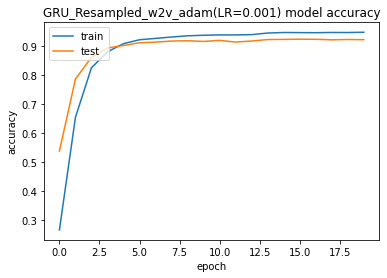

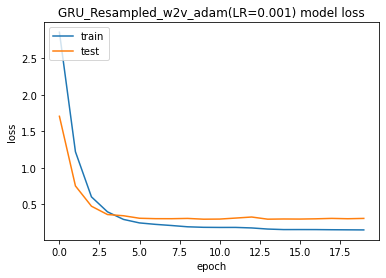

description  val_accuracy  val_loss  \
0         LSTM_Raw_w2v_adam(LR=0.001)      0.580000  2.087598   
1   LSTM_Resampled_w2v_adam(LR=0.001)      0.922390  0.303842   
2   LSTM_Resampled_w2v_adam(LR=0.001)      0.922995  0.287431   
3   LSTM_Resampled_glv_adam(LR=0.001)      0.924206  0.299497   
4  LSTM_Resampled_ftxt_adam(LR=0.001)      0.922542  0.299838   
5    GRU_Resampled_w2v_adam(LR=0.001)      0.922239  0.295984   

   training_accuracy  training_loss  test_accuracy  test_f1_score  
0           0.707721       1.019307       0.547794       0.517140  
1           0.944213       0.155587       0.921331       0.922836  
2           0.943173       0.160881       0.922088       0.923463  
3           0.944733       0.153596       0.920008       0.921391  
4           0.942700       0.160521       0.922277       0.923854  
5           0.944875       0.151942       0.922277       0.923372

In [87]:
model, run_name, history, accuracy, f1_score, test_pred = run_model(res_data, 'GRU', 'Resampled', 'w2v', 100, 20)
results = update_results(run_name, history, accuracy, f1_score)
results

### Model 6: Deep RNN with resampled data and W2V embedding

In [88]:
def create_DRNN_model(maxlen,num_words,embedding_matrix,num_categories, opt):    
    model = Sequential()
    model.add(Embedding(num_words,output_dim=100,input_length=maxlen, weights = [embedding_matrix], trainable=True))
    model.add(LSTM(128,return_sequences=True))
    model.add(LSTM(128,return_sequences=True))
    model.add(Dropout(0.3))
    model.add(TimeDistributed(Dense(128,activation='relu')))
    model.add(Flatten())
    model.add(Dense(num_categories, activation='softmax'))
              
    model.compile(loss='sparse_categorical_crossentropy',optimizer=opt,metrics=['accuracy'])

    model.summary()
    return model

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 300, 100)          861800    
_________________________________________________________________
lstm_5 (LSTM)                (None, 300, 128)          117248    
_________________________________________________________________
lstm_6 (LSTM)                (None, 300, 128)          131584    
_________________________________________________________________
dropout_6 (Dropout)          (None, 300, 128)          0         
_________________________________________________________________
time_distributed (TimeDistri (None, 300, 128)          16512     
_________________________________________________________________
flatten (Flatten)            (None, 38400)             0         
_________________________________________________________________
dense_18 (Dense)             (None, 50)               

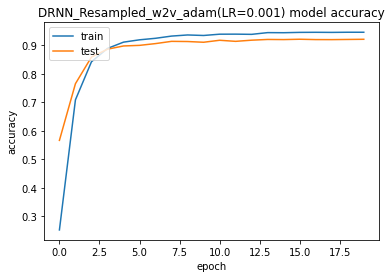

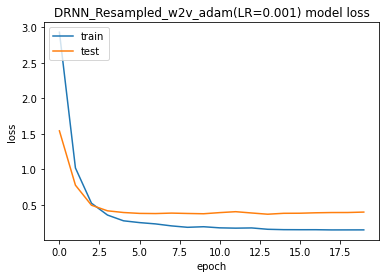

description  val_accuracy  val_loss  \
0         LSTM_Raw_w2v_adam(LR=0.001)      0.580000  2.087598   
1   LSTM_Resampled_w2v_adam(LR=0.001)      0.922390  0.303842   
2   LSTM_Resampled_w2v_adam(LR=0.001)      0.922995  0.287431   
3   LSTM_Resampled_glv_adam(LR=0.001)      0.924206  0.299497   
4  LSTM_Resampled_ftxt_adam(LR=0.001)      0.922542  0.299838   
5    GRU_Resampled_w2v_adam(LR=0.001)      0.922239  0.295984   
6   DRNN_Resampled_w2v_adam(LR=0.001)      0.921331  0.381825   

   training_accuracy  training_loss  test_accuracy  test_f1_score  
0           0.707721       1.019307       0.547794       0.517140  
1           0.944213       0.155587       0.921331       0.922836  
2           0.943173       0.160881       0.922088       0.923463  
3           0.944733       0.153596       0.920008       0.921391  
4           0.942700       0.160521       0.922277       0.923854  
5           0.944875       0.151942       0.922277       0.923372  
6           0.945395       0.149597       0.920008       0.921502

In [89]:
model, run_name, history, accuracy, f1_score, test_pred = run_model(res_data, 'DRNN', 'Resampled', 'w2v', 100, 20)
results = update_results(run_name, history, accuracy, f1_score)
results

### Model 7-9: LSTM with resampled data - different optimizers

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 300, 100)          861800    
_________________________________________________________________
bidirectional_5 (Bidirection (None, 256)               234496    
_________________________________________________________________
dropout_7 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_19 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_20 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_21 (Dense)             (None, 50)                6450      
Total params: 1,152,154
Trainable params: 1,152,154
Non-trainable params: 0
____________________________________________

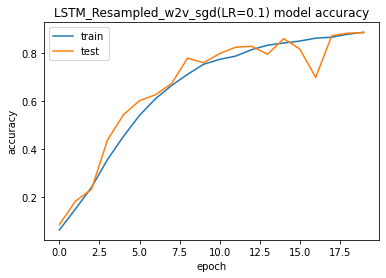

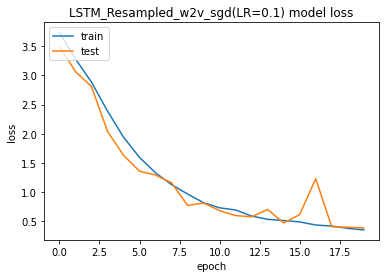

description  val_accuracy  val_loss  \
0         LSTM_Raw_w2v_adam(LR=0.001)      0.580000  2.087598   
1   LSTM_Resampled_w2v_adam(LR=0.001)      0.922390  0.303842   
2   LSTM_Resampled_w2v_adam(LR=0.001)      0.922995  0.287431   
3   LSTM_Resampled_glv_adam(LR=0.001)      0.924206  0.299497   
4  LSTM_Resampled_ftxt_adam(LR=0.001)      0.922542  0.299838   
5    GRU_Resampled_w2v_adam(LR=0.001)      0.922239  0.295984   
6   DRNN_Resampled_w2v_adam(LR=0.001)      0.921331  0.381825   
7      LSTM_Resampled_w2v_sgd(LR=0.1)      0.884569  0.386582   

   training_accuracy  training_loss  test_accuracy  test_f1_score  
0           0.707721       1.019307       0.547794       0.517140  
1           0.944213       0.155587       0.921331       0.922836  
2           0.943173       0.160881       0.922088       0.923463  
3           0.944733       0.153596       0.920008       0.921391  
4           0.942700       0.160521       0.922277       0.923854  
5           0.944875       0.151942       0.922277       0.923372  
6           0.945395       0.149597       0.920008       0.921502  
7           0.886157       0.352067       0.875000       0.875646

In [90]:
model, run_name, history, accuracy, f1_score, test_pred = run_model(res_data, 'LSTM', 'Resampled', 'w2v', 100, 20, 'sgd', 0.1)
results = update_results(run_name, history, accuracy, f1_score)
results


Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 300, 100)          861800    
_________________________________________________________________
bidirectional_6 (Bidirection (None, 256)               234496    
_________________________________________________________________
dropout_8 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_23 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_24 (Dense)             (None, 50)                6450      
Total params: 1,152,154
Trainable params: 1,152,154
Non-trainable params: 0
____________________________________________

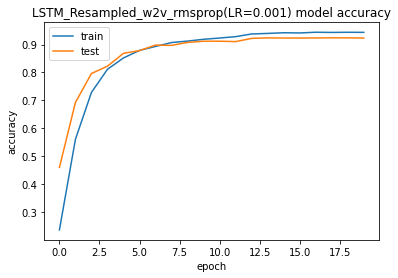

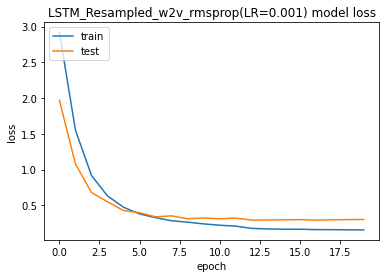

description  val_accuracy  val_loss  \
0           LSTM_Raw_w2v_adam(LR=0.001)      0.580000  2.087598   
1     LSTM_Resampled_w2v_adam(LR=0.001)      0.922390  0.303842   
2     LSTM_Resampled_w2v_adam(LR=0.001)      0.922995  0.287431   
3     LSTM_Resampled_glv_adam(LR=0.001)      0.924206  0.299497   
4    LSTM_Resampled_ftxt_adam(LR=0.001)      0.922542  0.299838   
5      GRU_Resampled_w2v_adam(LR=0.001)      0.922239  0.295984   
6     DRNN_Resampled_w2v_adam(LR=0.001)      0.921331  0.381825   
7        LSTM_Resampled_w2v_sgd(LR=0.1)      0.884569  0.386582   
8  LSTM_Resampled_w2v_rmsprop(LR=0.001)      0.924054  0.296873   

   training_accuracy  training_loss  test_accuracy  test_f1_score  
0           0.707721       1.019307       0.547794       0.517140  
1           0.944213       0.155587       0.921331       0.922836  
2           0.943173       0.160881       0.922088       0.923463  
3           0.944733       0.153596       0.920008       0.921391  
4           0.942700       0.160521       0.922277       0.923854  
5           0.944875       0.151942       0.922277       0.923372  
6           0.945395       0.149597       0.920008       0.921502  
7           0.886157       0.352067       0.875000       0.875646  
8           0.943315       0.159721       0.923411       0.925641

In [91]:
model, run_name, history, accuracy, f1_score, test_pred = run_model(res_data, 'LSTM', 'Resampled', 'w2v', 100, 20, 'rmsprop')
results = update_results(run_name, history, accuracy, f1_score)
results


Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 300, 100)          861800    
_________________________________________________________________
bidirectional_7 (Bidirection (None, 256)               234496    
_________________________________________________________________
dropout_9 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_25 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_26 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_27 (Dense)             (None, 50)                6450      
Total params: 1,152,154
Trainable params: 1,152,154
Non-trainable params: 0
____________________________________________

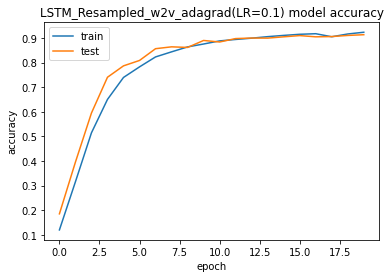

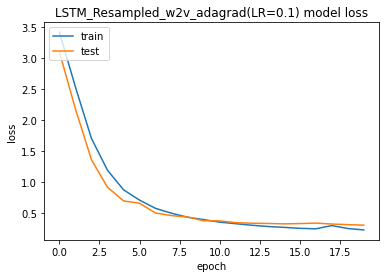

description  val_accuracy  val_loss  \
0           LSTM_Raw_w2v_adam(LR=0.001)      0.580000  2.087598   
1     LSTM_Resampled_w2v_adam(LR=0.001)      0.922390  0.303842   
2     LSTM_Resampled_w2v_adam(LR=0.001)      0.922995  0.287431   
3     LSTM_Resampled_glv_adam(LR=0.001)      0.924206  0.299497   
4    LSTM_Resampled_ftxt_adam(LR=0.001)      0.922542  0.299838   
5      GRU_Resampled_w2v_adam(LR=0.001)      0.922239  0.295984   
6     DRNN_Resampled_w2v_adam(LR=0.001)      0.921331  0.381825   
7        LSTM_Resampled_w2v_sgd(LR=0.1)      0.884569  0.386582   
8  LSTM_Resampled_w2v_rmsprop(LR=0.001)      0.924054  0.296873   
9    LSTM_Resampled_w2v_adagrad(LR=0.1)      0.913011  0.299096   

   training_accuracy  training_loss  test_accuracy  test_f1_score  
0           0.707721       1.019307       0.547794       0.517140  
1           0.944213       0.155587       0.921331       0.922836  
2           0.943173       0.160881       0.922088       0.923463  
3           0.944733       0.153596       0.920008       0.921391  
4           0.942700       0.160521       0.922277       0.923854  
5           0.944875       0.151942       0.922277       0.923372  
6           0.945395       0.149597       0.920008       0.921502  
7           0.886157       0.352067       0.875000       0.875646  
8           0.943315       0.159721       0.923411       0.925641  
9           0.922986       0.221868       0.913956       0.915133

In [92]:
model, run_name, history, accuracy, f1_score, test_pred = run_model(res_data, 'LSTM', 'Resampled', 'w2v', 100, 20, 'adagrad', 0.1)
results = update_results(run_name, history, accuracy, f1_score)
results


### Model Selection and Evaluation

Most models perform well and the accuracy and F1 scores are very close. We choose the model with the highest F1 score, namely, LSTM with resampled data, Word2Vec embedding and Adam optimizer to go forward and get a range for the performance.

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 300, 100)          861800    
_________________________________________________________________
bidirectional_8 (Bidirection (None, 256)               234496    
_________________________________________________________________
dropout_10 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_28 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_29 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_30 (Dense)             (None, 50)                6450      
Total params: 1,152,154
Trainable params: 1,152,154
Non-trainable params: 0
____________________________________________

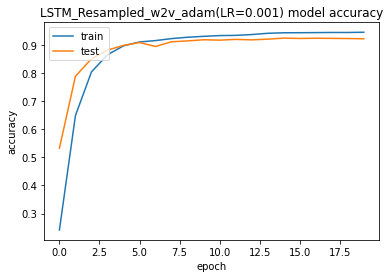

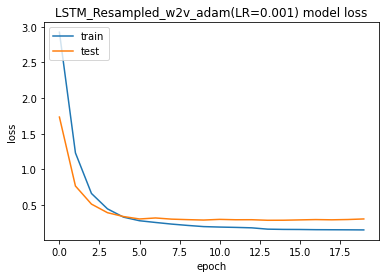

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 300, 100)          861800    
_________________________________________________________________
bidirectional_9 (Bidirection (None, 256)               234496    
_________________________________________________________________
dropout_11 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_31 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_32 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_33 (Dense)             (None, 50)                6450      
Total params: 1,152,154
Trainable params: 1,152,154
Non-trainable params: 0
___________________________________________

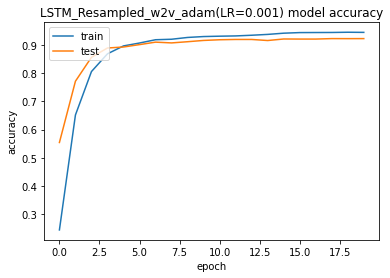

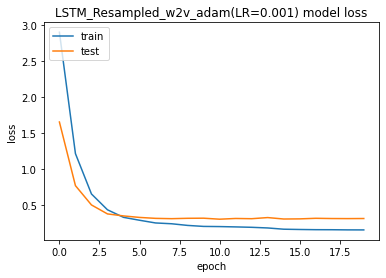

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 300, 100)          861800    
_________________________________________________________________
bidirectional_10 (Bidirectio (None, 256)               234496    
_________________________________________________________________
dropout_12 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_34 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_35 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_36 (Dense)             (None, 50)                6450      
Total params: 1,152,154
Trainable params: 1,152,154
Non-trainable params: 0
___________________________________________

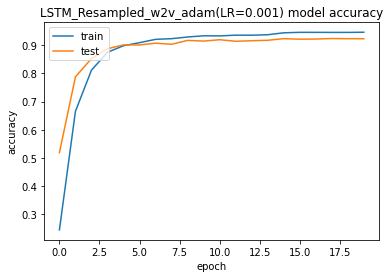

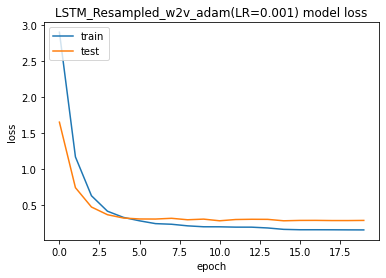

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, 300, 100)          861800    
_________________________________________________________________
bidirectional_11 (Bidirectio (None, 256)               234496    
_________________________________________________________________
dropout_13 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_37 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_38 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_39 (Dense)             (None, 50)                6450      
Total params: 1,152,154
Trainable params: 1,152,154
Non-trainable params: 0
___________________________________________

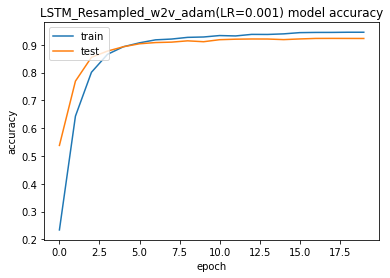

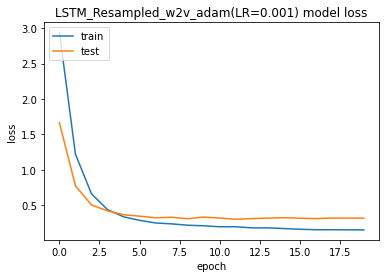

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_14 (Embedding)     (None, 300, 100)          861800    
_________________________________________________________________
bidirectional_12 (Bidirectio (None, 256)               234496    
_________________________________________________________________
dropout_14 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_40 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_41 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_42 (Dense)             (None, 50)                6450      
Total params: 1,152,154
Trainable params: 1,152,154
Non-trainable params: 0
___________________________________________

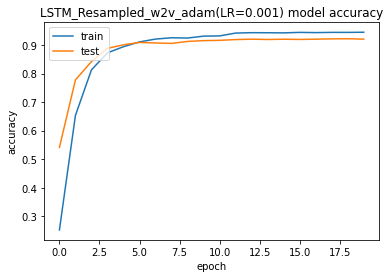

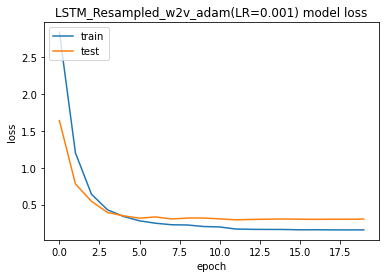

In [93]:
random_states = [1, 17, 23, 100, 1000]

training_accuarcy_score = []
validation_accuarcy_score = []
test_accuracy = []
test_f1 = []

for rs in random_states:
    _, _, history, accuracy, f1_score, _ = run_model(res_data, 'LSTM', 'Resampled', 'w2v', 100, 20, 'adam', 0.001, False, rs)
    top_id = np.argmax(history.history['val_accuracy'])
    training_accuarcy_score.append(history.history['accuracy'][top_id])
    validation_accuarcy_score.append(history.history['val_accuracy'][top_id])
    test_accuracy.append(accuracy)
    test_f1.append(f1_score)


In [94]:
print(training_accuarcy_score )
print(validation_accuarcy_score )
print(test_accuracy )
print(test_f1)

[0.9435041546821594, 0.9445915222167969, 0.944875180721283, 0.94454425573349, 0.9440242052078247]
[0.9245083332061768, 0.9228441715240479, 0.9231467247009277, 0.9229954481124878, 0.9217851758003235]
[0.925302571860817, 0.9215204236006052, 0.9213313161875946, 0.9224659606656581, 0.9218986384266263]
[0.9273361464285083, 0.9227786709323414, 0.9231604560633158, 0.9242770778229352, 0.9234149121626842]


In [95]:
print("Average Accuracy: " , np.mean(test_accuracy))
print("Min Accuracy: " , np.min(test_accuracy))
print("Max Accuracy: " , np.max(test_accuracy))
print("Variance of Accuracy: " , np.var(test_accuracy))

print("Average F1 Score: " , np.mean(test_f1))
print("Min F1 Score: " , np.min(test_f1))
print("Max F1 Score: " , np.max(test_f1))
print("Variance of F1 Score: " , np.var(test_f1))

Average Accuracy:  0.9225037821482601
Min Accuracy:  0.9213313161875946
Max Accuracy:  0.925302571860817
Variance of Accuracy:  2.108504741131733e-06
Average F1 Score:  0.924193452681957
Min F1 Score:  0.9227786709323414
Max F1 Score:  0.9273361464285083
Variance of F1 Score:  2.7116663804269976e-06


The performance accuracy and F1 score is consistently 0.92 with little a miniscule variance. Random state 17 gives the best result, so we will get the confusion matrix for the same to study the mis-classified tickets.

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_15 (Embedding)     (None, 300, 100)          861800    
_________________________________________________________________
bidirectional_13 (Bidirectio (None, 256)               234496    
_________________________________________________________________
dropout_15 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_43 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_44 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_45 (Dense)             (None, 50)                6450      
Total params: 1,152,154
Trainable params: 1,152,154
Non-trainable params: 0
___________________________________________

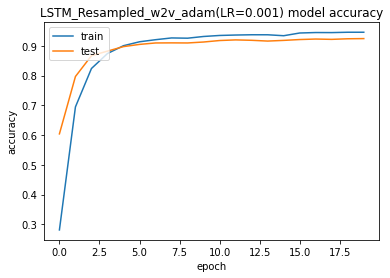

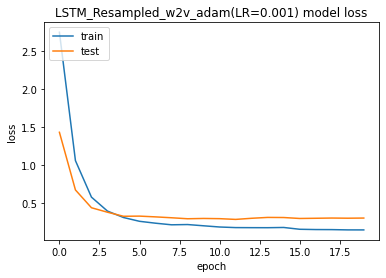

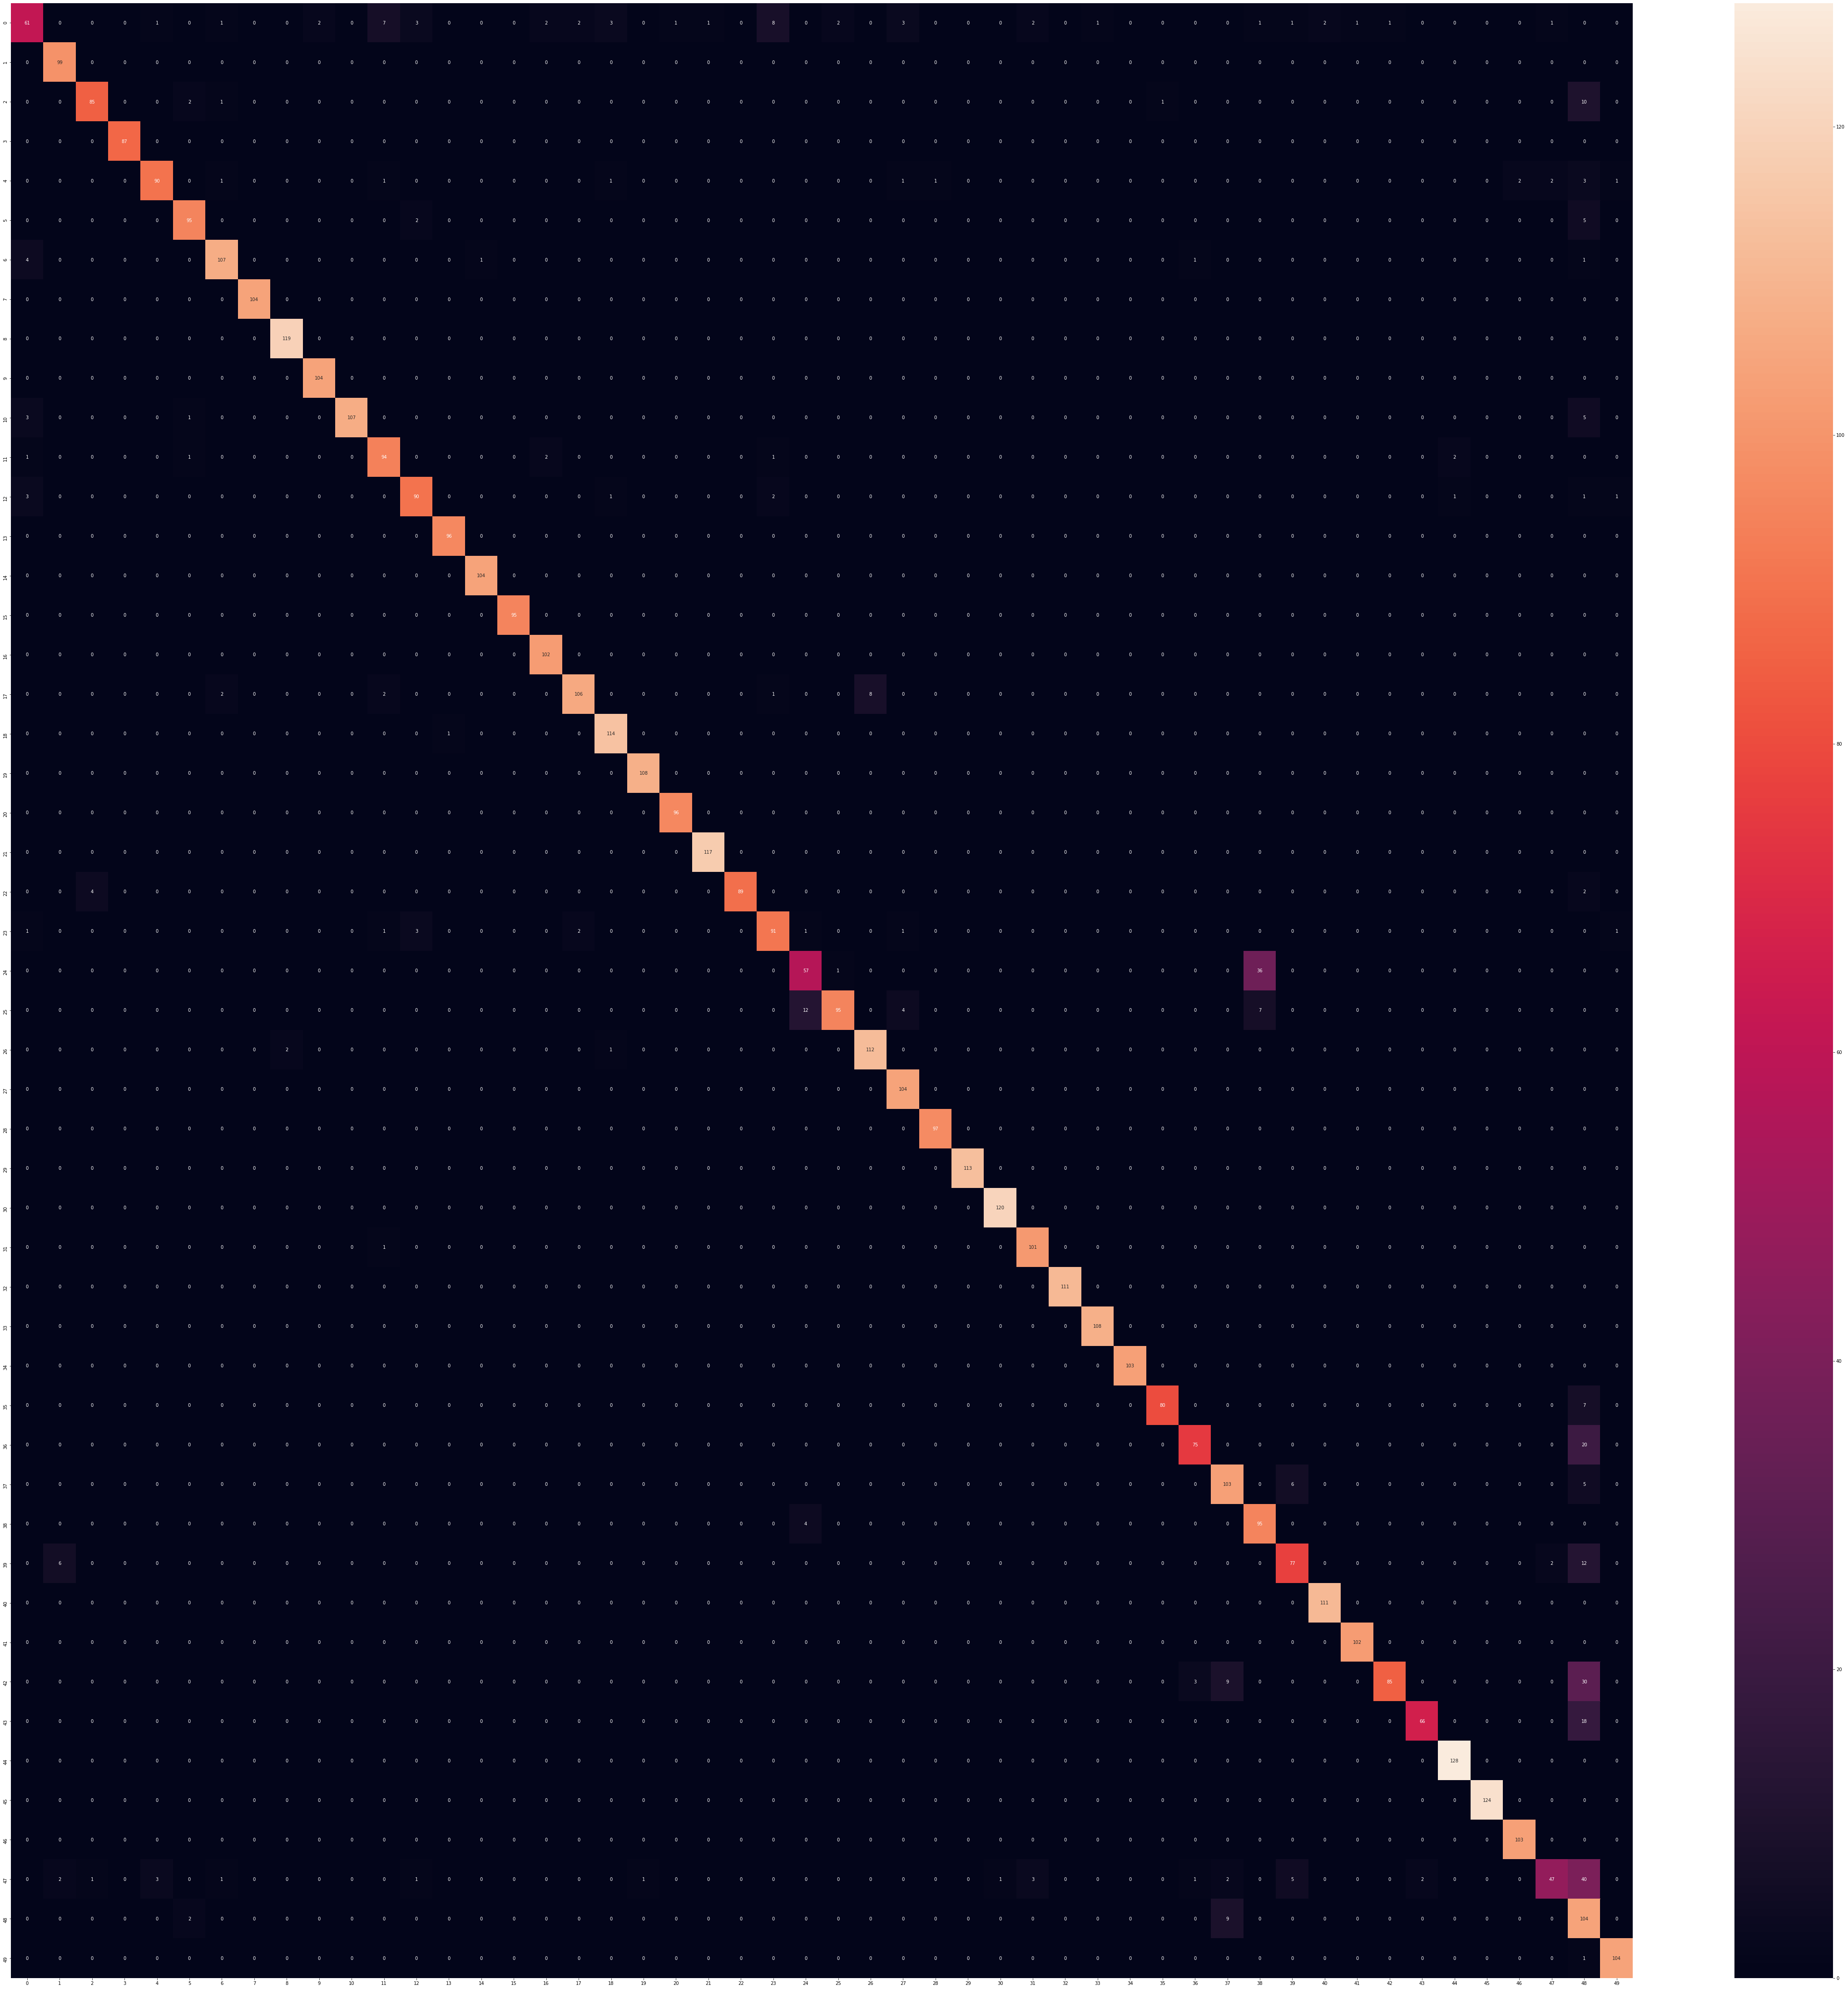

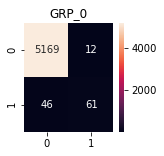

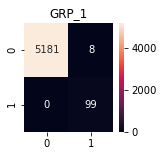

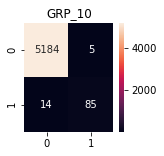

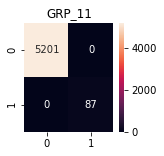

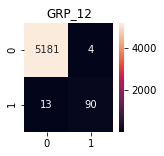

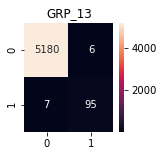

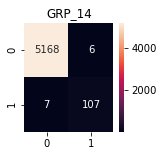

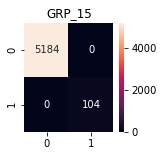

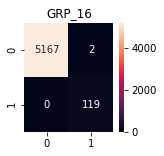

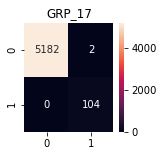

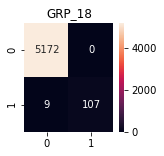

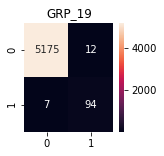

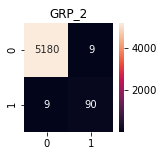

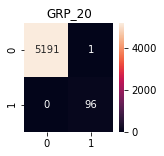

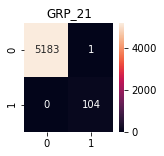

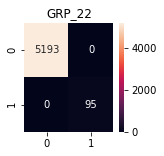

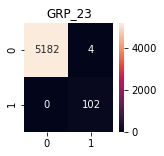

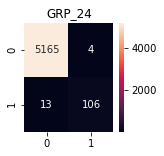

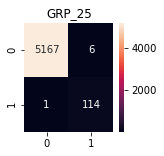

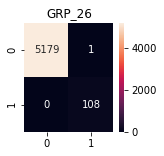

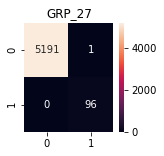

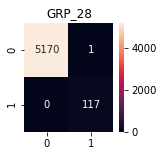

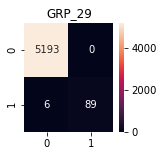

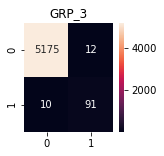

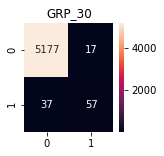

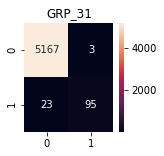

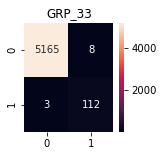

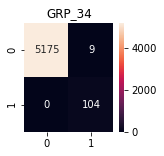

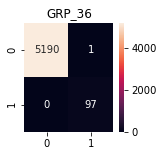

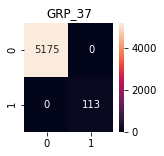

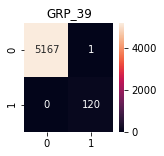

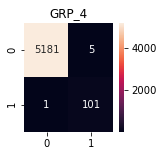

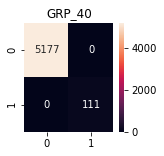

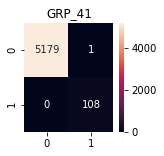

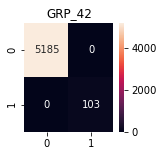

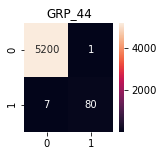

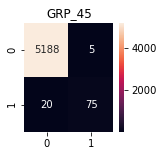

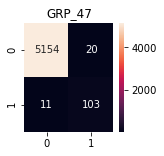

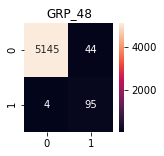

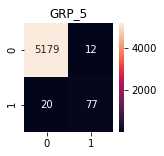

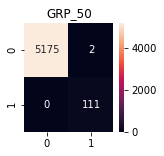

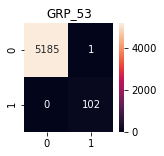

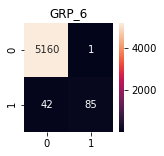

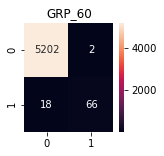

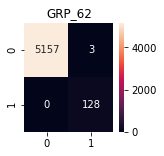

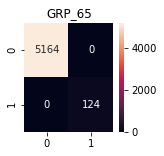

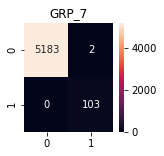

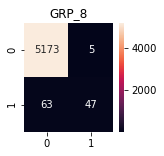

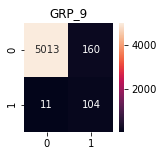

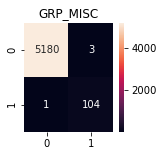

In [96]:
model, run_name, history, accuracy, f1_score, test_predr = run_model(res_data, 'LSTM', 'Resampled', 'w2v', 80, 20, 'adam', 0.001, True, 17)

### Conclusion

Looking at the confusion matrix, most mis-classification has taken place by assigning tickets from Groups 5,6,8,10,45 and 60 to Group 9. Looking at these groups, the main cause for this is that Group 9 consists of mostly monitoring tool tickets which are difficult to be distinguished from those of other groups (common cleaned text: 'job fail scheduler'. There are more than 150 mis-classifications like this. It is likely that the upsampling of group 9 has emphasised this problem. 

One solution would be to add information to the emails coming from monitoring tools that would help with classifying them based on the business processes. 

Other mis-classifications are smaller in number and seem to be related to the tickets which had many unrecognisable symbols and as such had minimal data after data cleaning. It would help to understand the nature of those tickets to avoid such misclassifications.